In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Libraries

In [22]:
from fastai.vision import *
from fastai.callbacks import *
torch.cuda.set_device(7)

### Data

Normalize the raw MRI scans and zero out the background (any pixels with negative value gets zero value). If you don't zero the background, the model will have difficulty predicting the brain mask. Note that this step needs to be done just once for the training, validation, and test raw images.

In [26]:
from data_utils import *

In [27]:
f = data_dict['notl_brain_mr'];

In [28]:
# get data paths
train_paths, valid_paths, test1_paths, test2_paths = f()

In [29]:
train_ds = MRI_3D_Dataset(*train_paths)
valid_ds = MRI_3D_Dataset(*valid_paths)
test1_ds = MRI_3D_Dataset(*test1_paths)
test2_ds = MRI_3D_Dataset(*test2_paths)

In [30]:
bs = 2
data = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=bs)
test1_dl = DeviceDataLoader(DataLoader(test1_ds), device=data.device)
test2_dl = DeviceDataLoader(DataLoader(test2_ds), device=data.device)

### Models

In [13]:
from models import *

In [15]:
f = model_dict['unet_default']; m = f(); m

VolumetricUnet(
  (downblocks): ModuleList(
    (0): UnetBegin(
      (conv_block1): Sequential(
        (0): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): PReLU(num_parameters=1)
        (2): GroupNorm(2, 4, eps=1e-05, affine=True)
        (3): Dropout3d(p=0.0)
      )
      (conv_block2): Sequential(
        (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): PReLU(num_parameters=1)
        (2): GroupNorm(2, 8, eps=1e-05, affine=True)
        (3): Dropout3d(p=0.0)
      )
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): UnetDownBlock(
      (conv_block1): Sequential(
        (0): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): PReLU(num_parameters=1)
        (2): GroupNorm(2, 8, eps=1e-05, affine=True)
        (3): Dropout3d(p=0.0)
      )
      (conv_block2): Sequential(
        (0): Conv3d(8, 16, kernel_size=(3, 

### Learner

In [31]:
from learn_utils import *

In [59]:
MODEL_NAME = 'MR_Brain_Scratch_Baseline_10'
model_dir = 'brain_notl_mr_models'
kaiming_init = True
lr = 1e-1

In [32]:
early_stop_cb = partial(EarlyStoppingCallback, monitor='dice_score', mode='max', patience=5)
save_model_cb = partial(SaveModelCallback, monitor='dice_score', mode='max', every='improvement', 
                        name=f'best_of_{MODEL_NAME}')
reduce_lr_cb = partial(ReduceLROnPlateauCallback, monitor='dice_score', mode='max', patience=0, factor=0.8)
csv_logger_cb = partial(CSVLogger, filename=f'logs/{model_dir}/{MODEL_NAME}')

callback_fns = [early_stop_cb, save_model_cb, reduce_lr_cb, csv_logger_cb]
callbacks = [TerminateOnNaNCallback()]

In [53]:
bn_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)
gnorm_types = (nn.GroupNorm,)
insnorm_types = (nn.InstanceNorm1d, nn.InstanceNorm2d, nn.InstanceNorm3d)
norm_types = bn_types + gnorm_types + insnorm_types

In [55]:
def cond_init(m:nn.Module, init_func:LayerFunc):
    "Initialize the non-batchnorm layers of `m` with `init_func`."
    if (not isinstance(m, norm_types)) and (not isinstance(m, nn.PReLU)) and
    requires_grad(m): init_default(m, init_func)

In [56]:
# %debug
learn = Learner(data=data, model=m, callbacks=callbacks, callback_fns=callback_fns, model_dir=model_dir)
if kaiming_init: apply_leaf(m, partial(cond_init, init_func= nn.init.kaiming_normal_))

In [57]:
learn.loss_func = dice_loss
learn.metrics = [dice_score]

In [58]:
learn.to_fp16();

In [60]:
learn.fit_one_cycle(100, max_lr=lr)

epoch,train_loss,valid_loss,dice_score,time
0,0.246899,0.114247,0.906552,02:32
1,0.129595,0.092947,0.915419,02:32
2,0.091291,0.065850,0.938368,02:31
3,0.075826,0.084457,0.918550,02:31
4,0.070921,0.057777,0.945286,02:32
5,0.064587,0.056087,0.945706,02:31
6,0.059512,0.056234,0.944704,02:31
7,0.056989,0.049326,0.951724,02:31
8,0.055083,0.058208,0.942226,02:31
9,0.065992,0.068251,0.932457,02:31


Better model found at epoch 0 with dice_score value: 0.9065519571304321.
Better model found at epoch 1 with dice_score value: 0.915418803691864.
Better model found at epoch 2 with dice_score value: 0.9383681416511536.
Epoch 3: reducing lr to 0.0065198544265241305
Better model found at epoch 4 with dice_score value: 0.9452863931655884.
Better model found at epoch 5 with dice_score value: 0.9457058310508728.
Epoch 6: reducing lr to 0.013063238701668069
Better model found at epoch 7 with dice_score value: 0.9517239928245544.
Epoch 8: reducing lr to 0.019029046311969035
Epoch 9: reducing lr to 0.0224
Epoch 10: reducing lr to 0.025981312905889266
Epoch 11: reducing lr to 0.029733747416002022
Epoch 12: reducing lr to 0.03361619107259805
Epoch 13: early stopping
Epoch 13: reducing lr to 0.03758610701052211


In [117]:
params = list(learn.model.parameters())

In [120]:
# valid score
learn.validate(learn.data.valid_dl, metrics=[dice_score])

[0.053187333, tensor(0.9487)]

In [122]:
learn.to_fp32();

In [123]:
# test1 score
learn.validate(test1_dl, metrics=[dice_score])

[0.04958387, tensor(0.9525)]

In [124]:
# test2 score
learn.validate(test2_dl, metrics=[dice_score])

[0.066236414, tensor(0.9362)]

### show preds

In [135]:
from unet import get_img_pred_masks

In [128]:
learn.to_fp16();

In [140]:
images, preds, masks = get_img_pred_masks(learn, test2_dl)

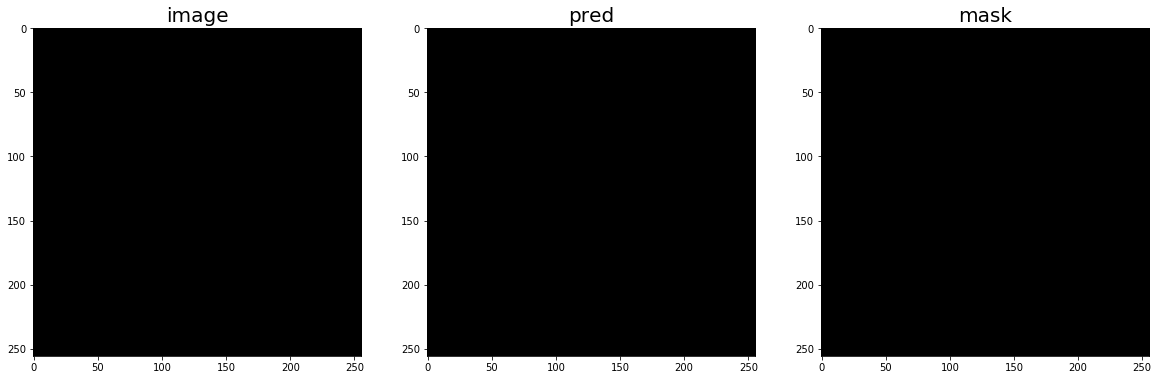

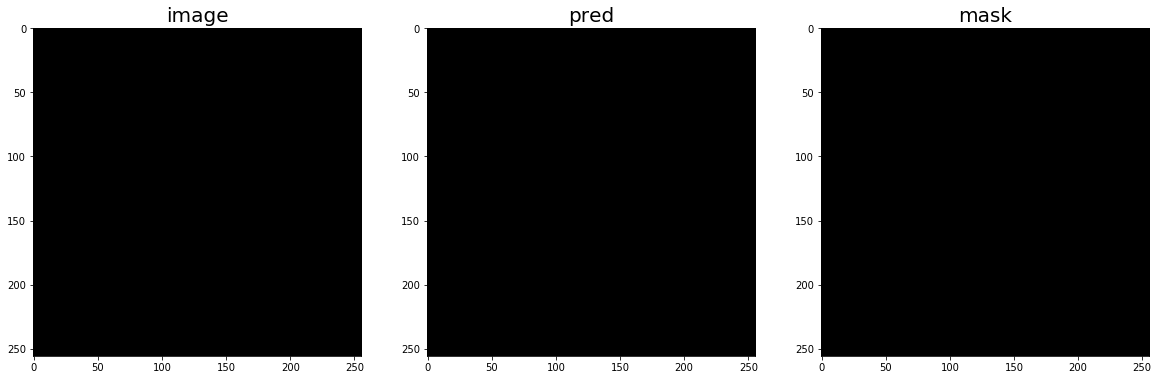

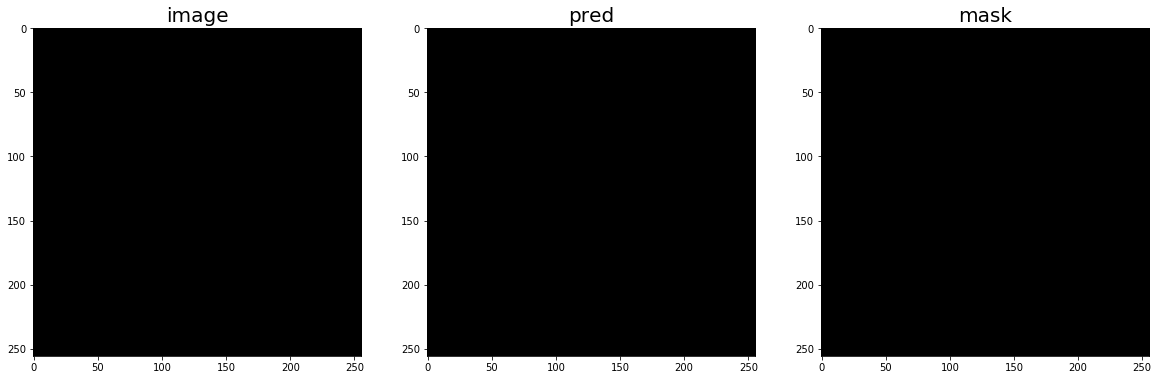

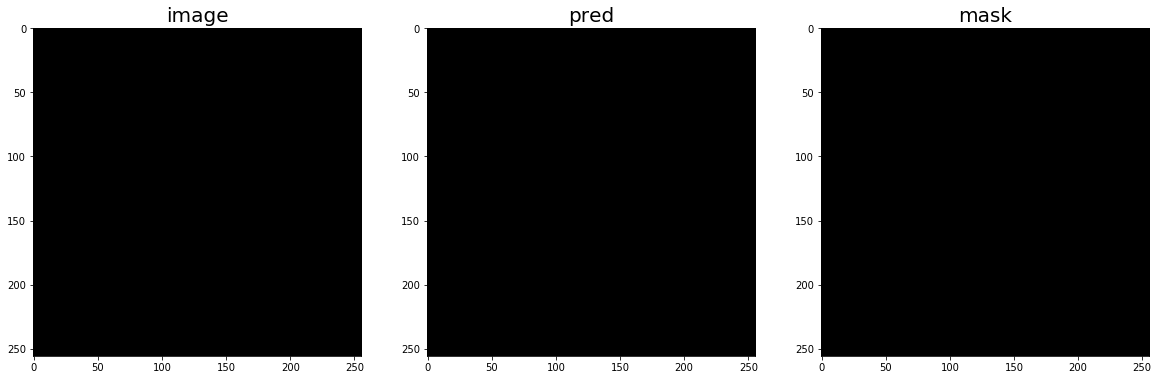

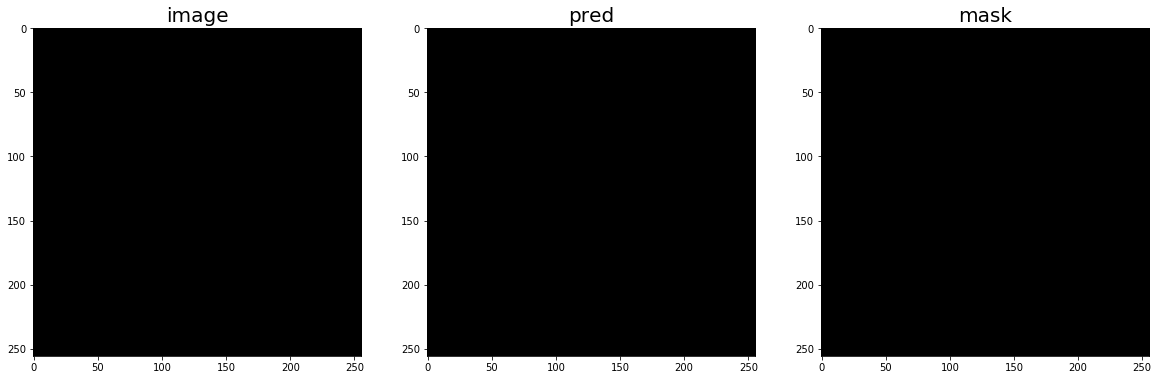

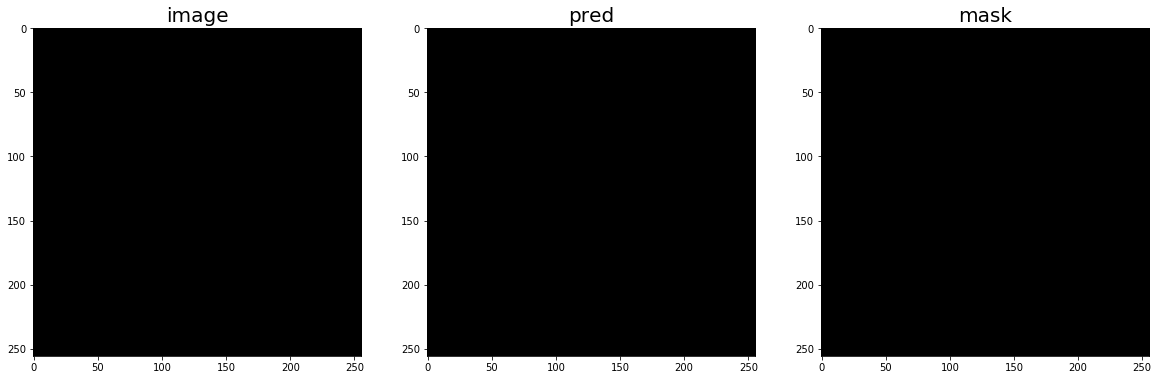

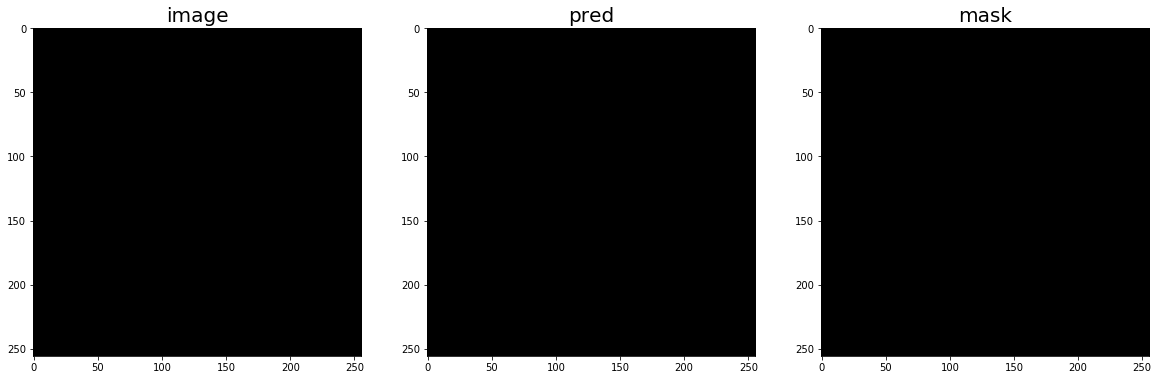

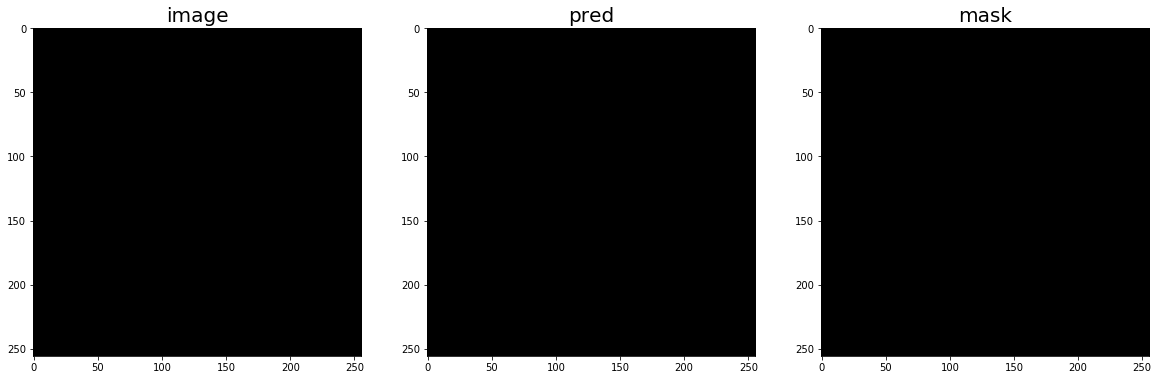

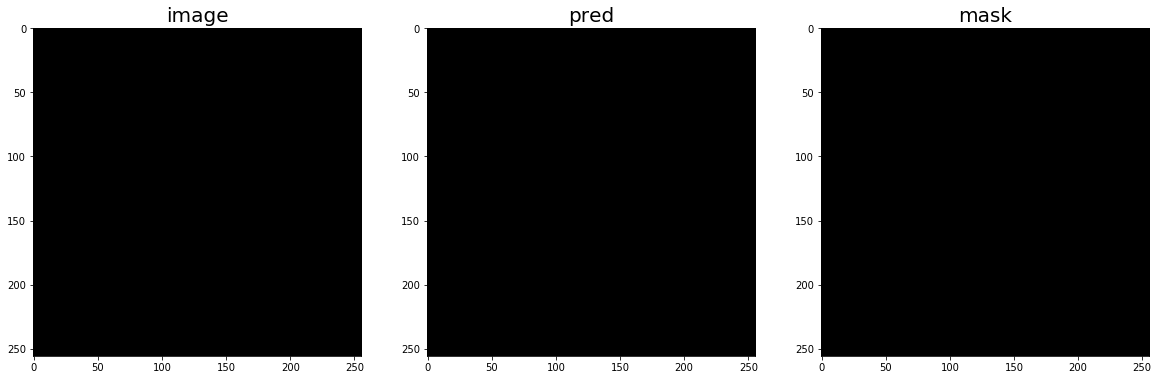

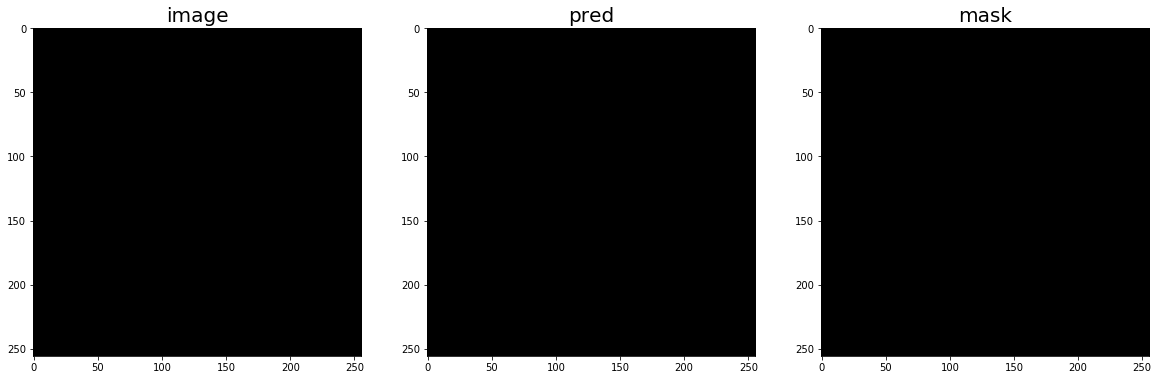

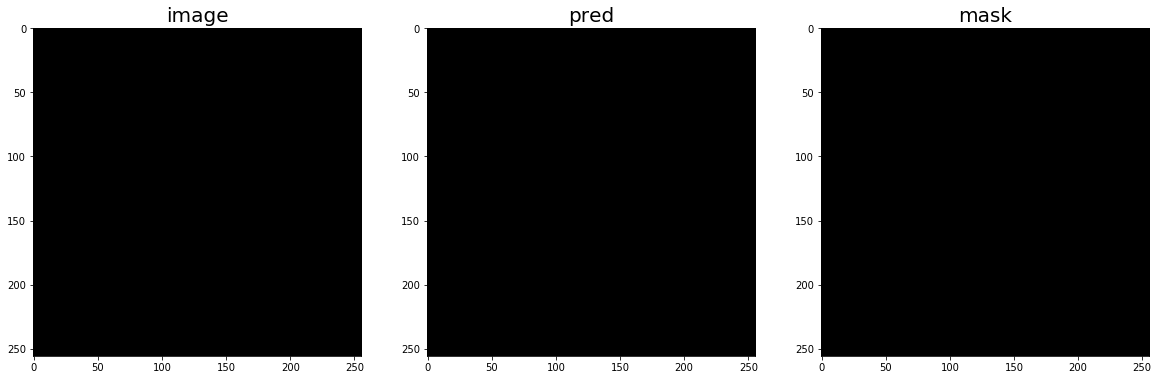

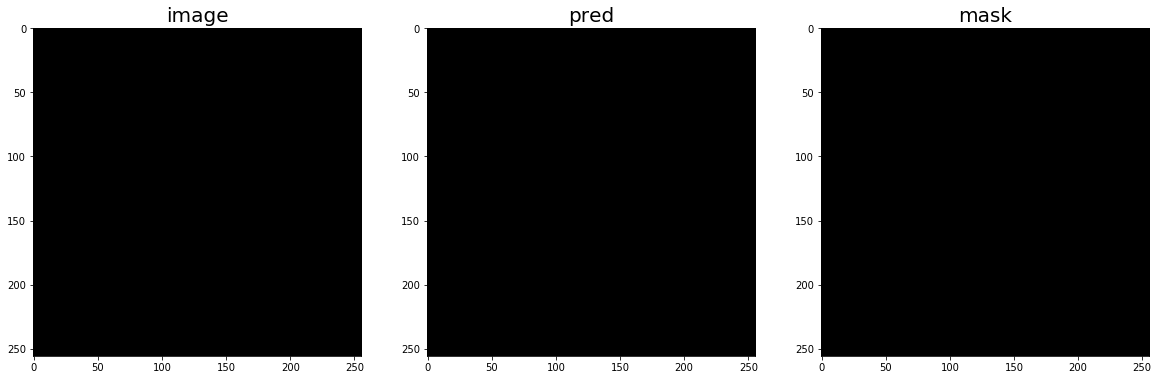

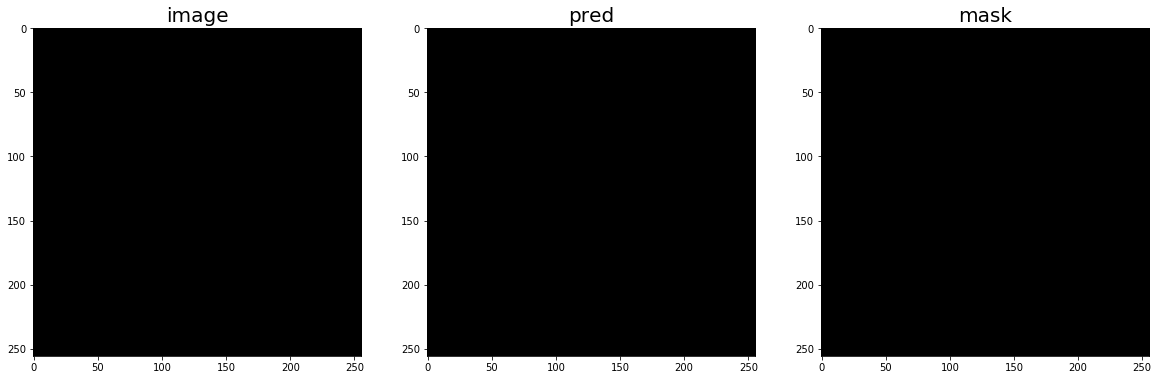

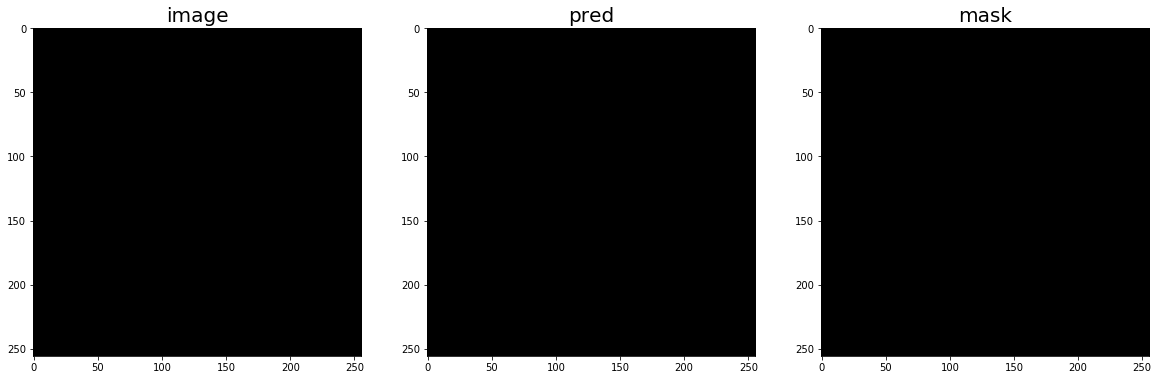

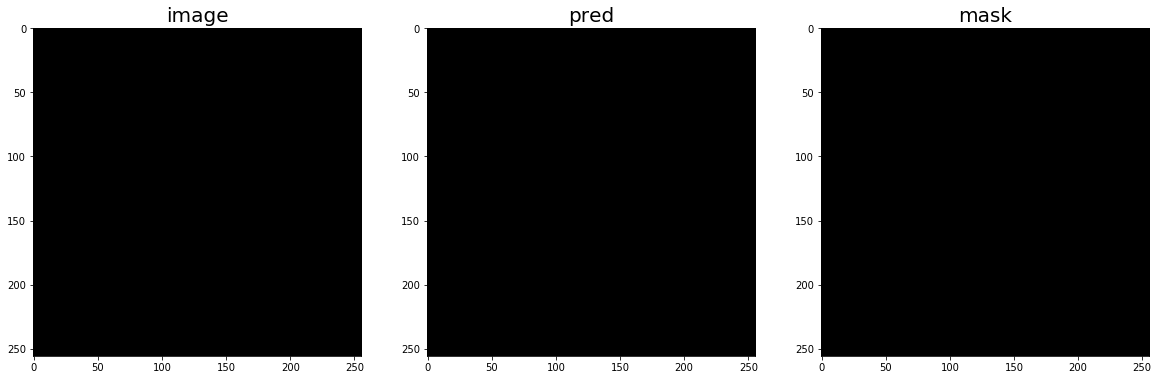

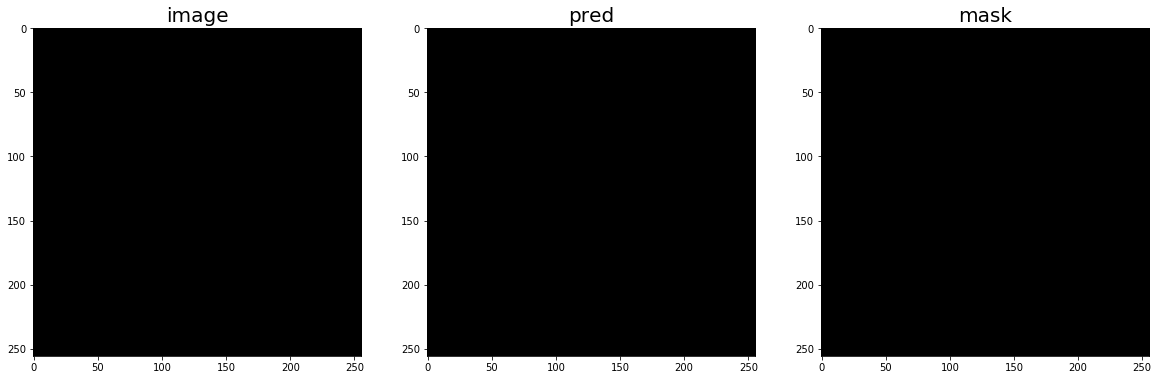

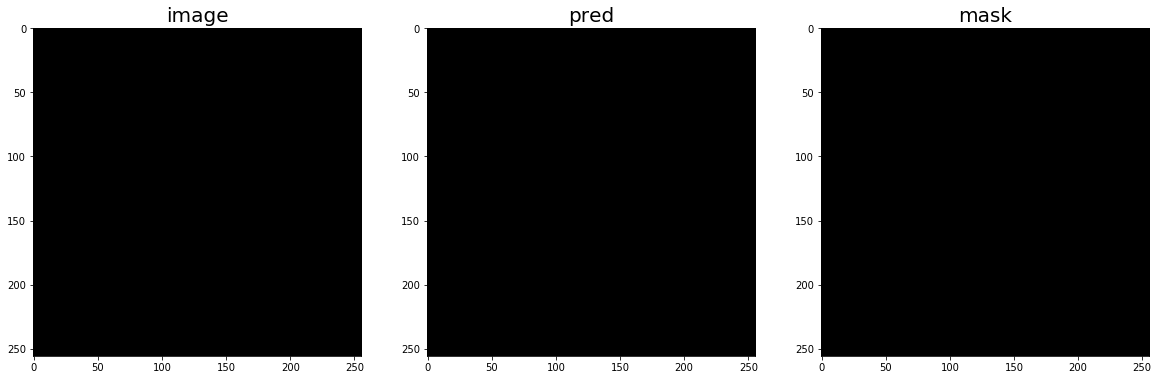

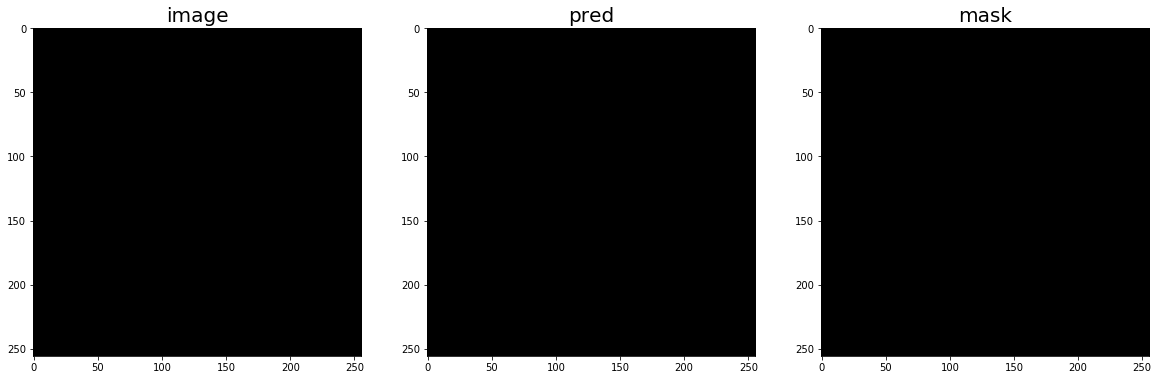

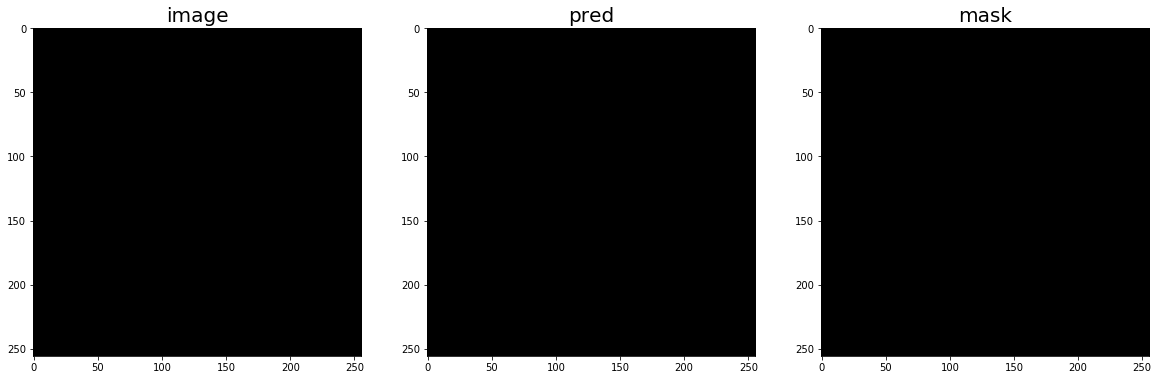

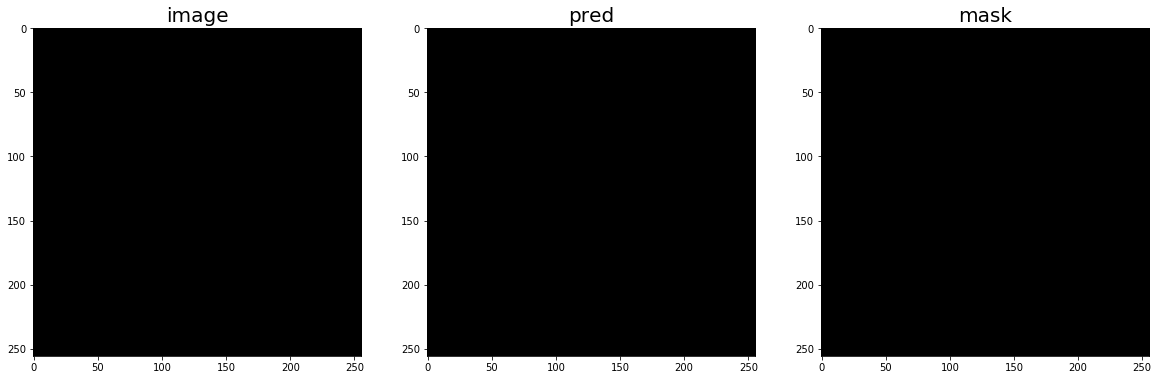

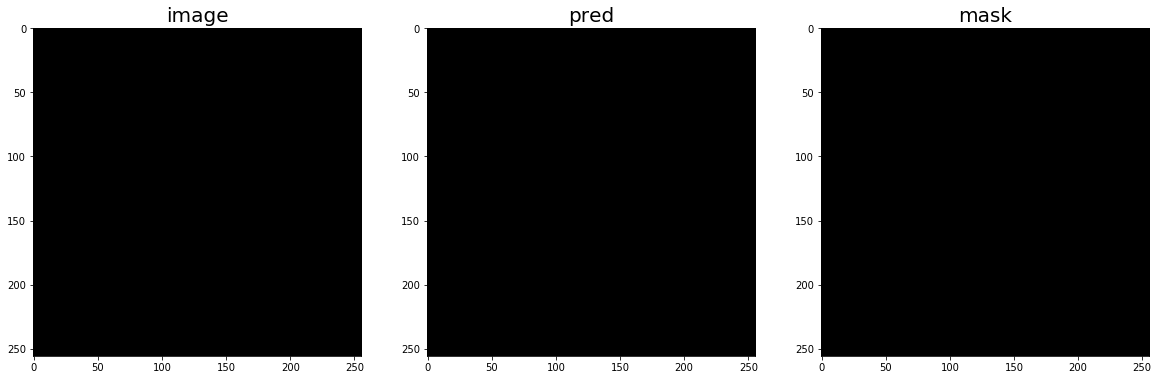

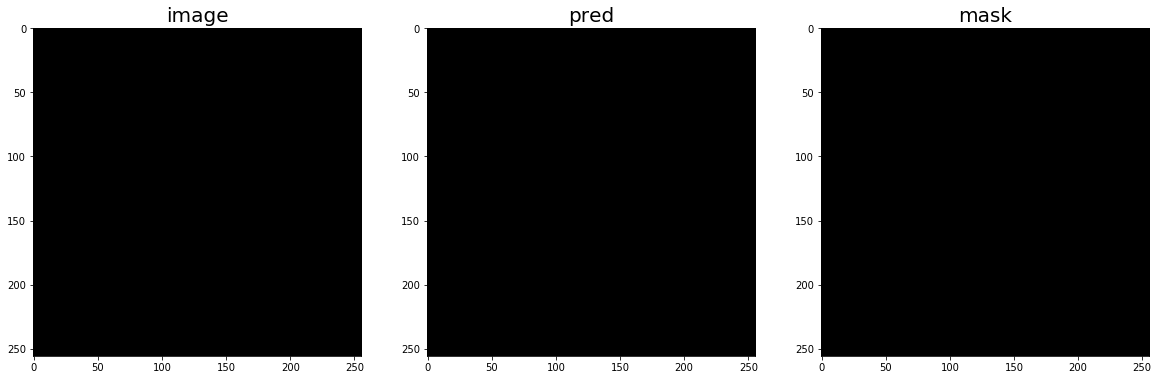

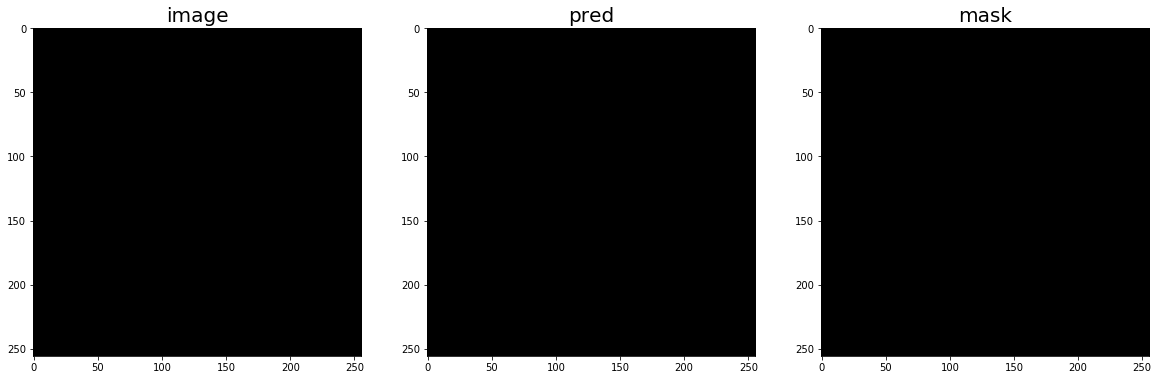

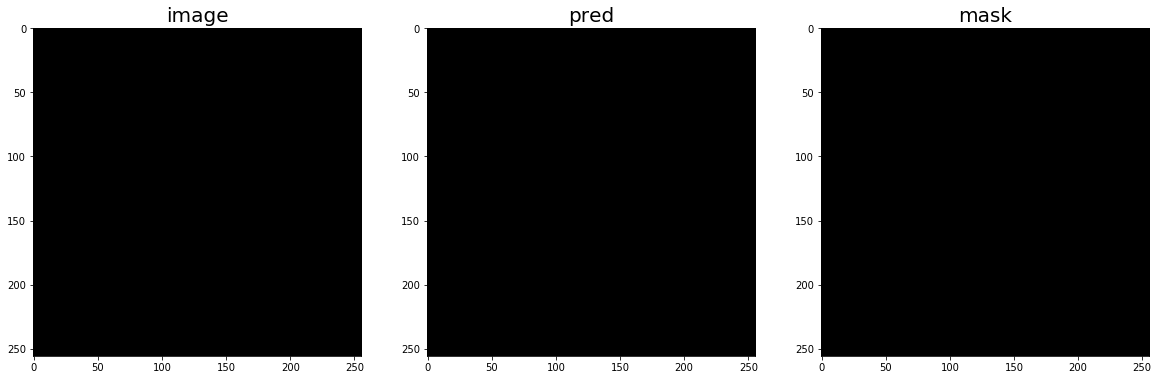

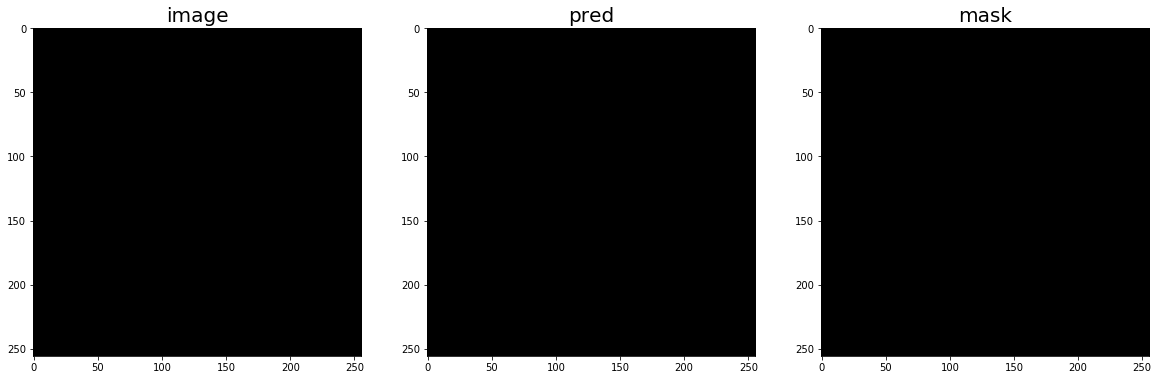

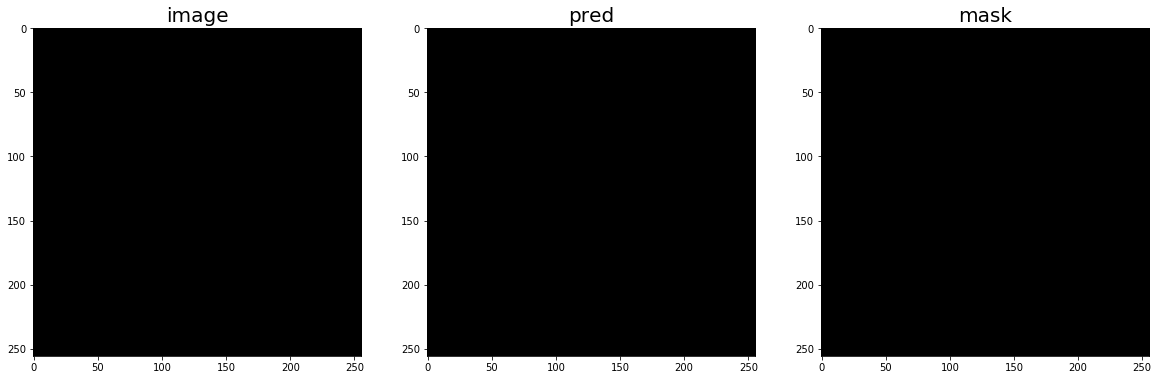

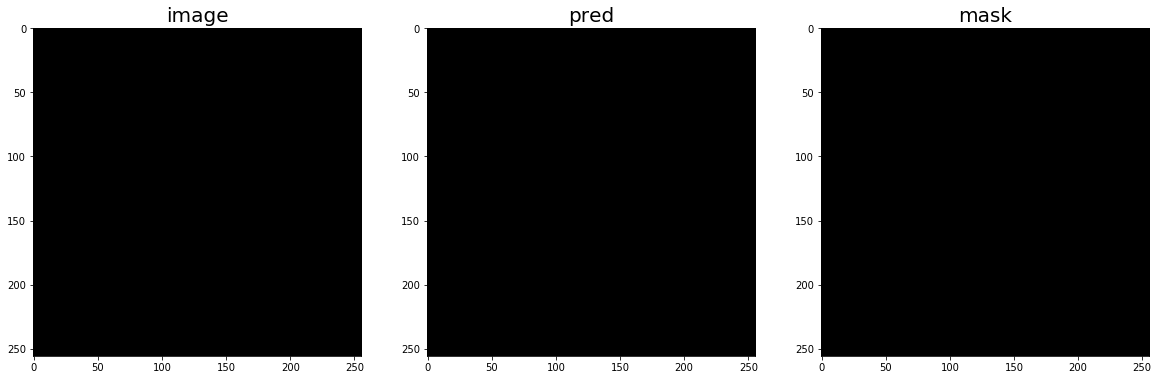

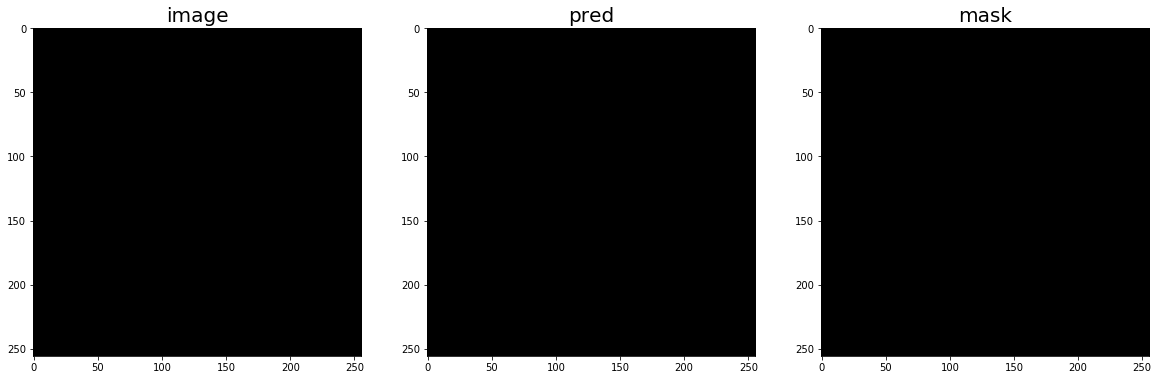

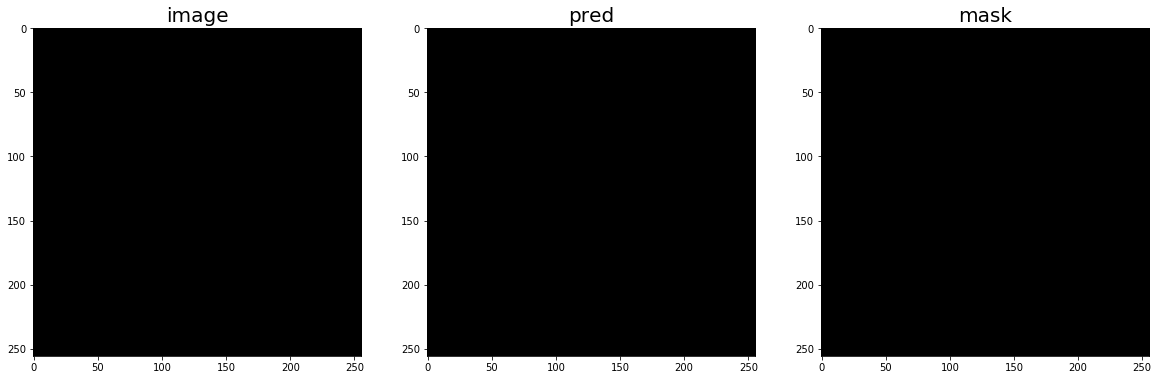

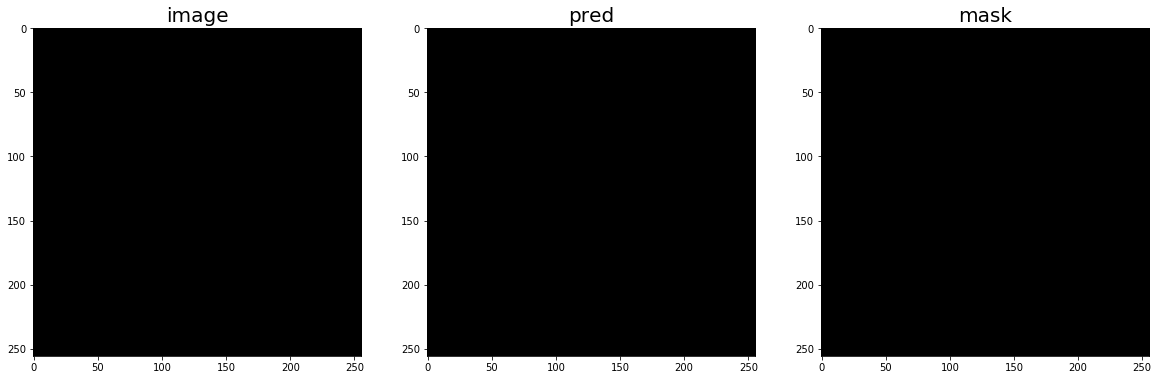

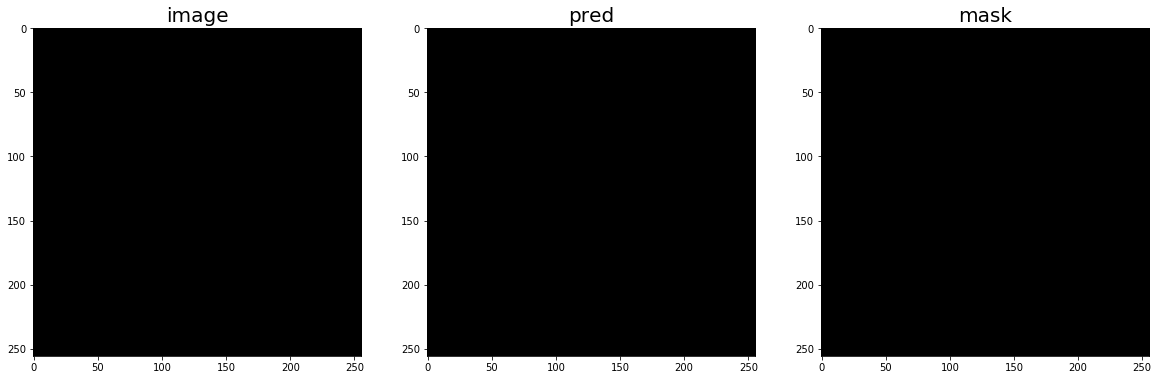

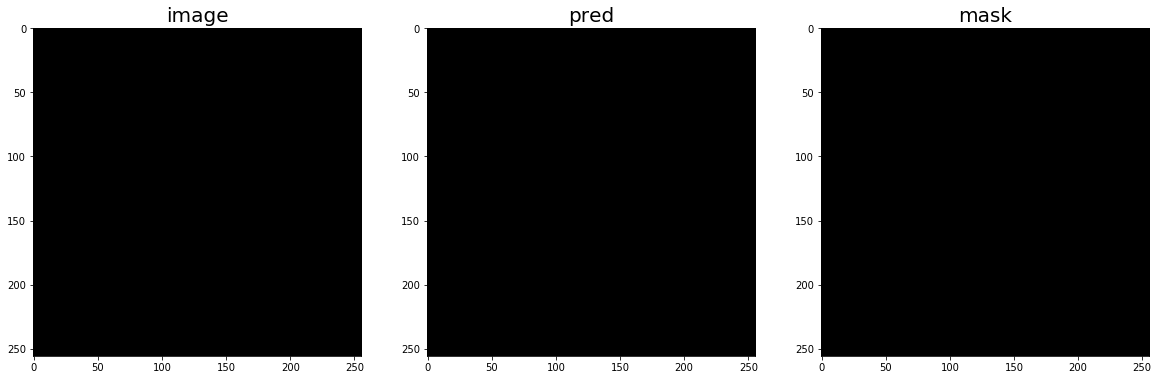

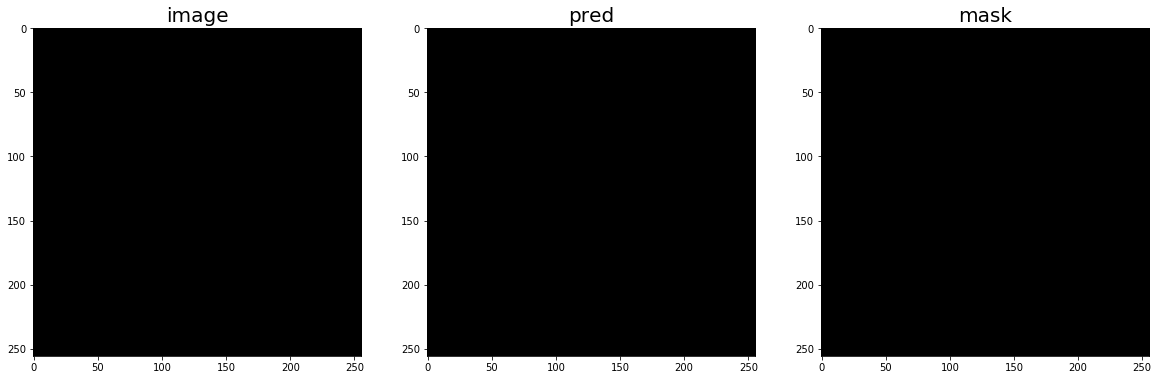

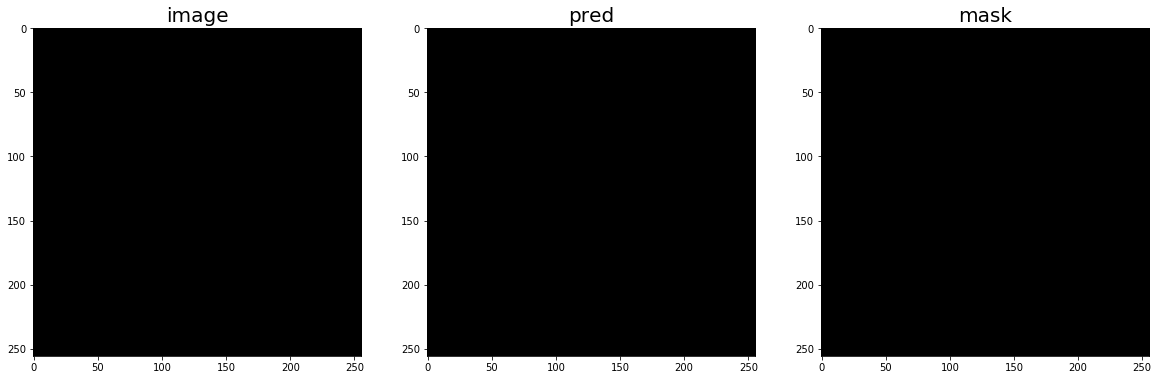

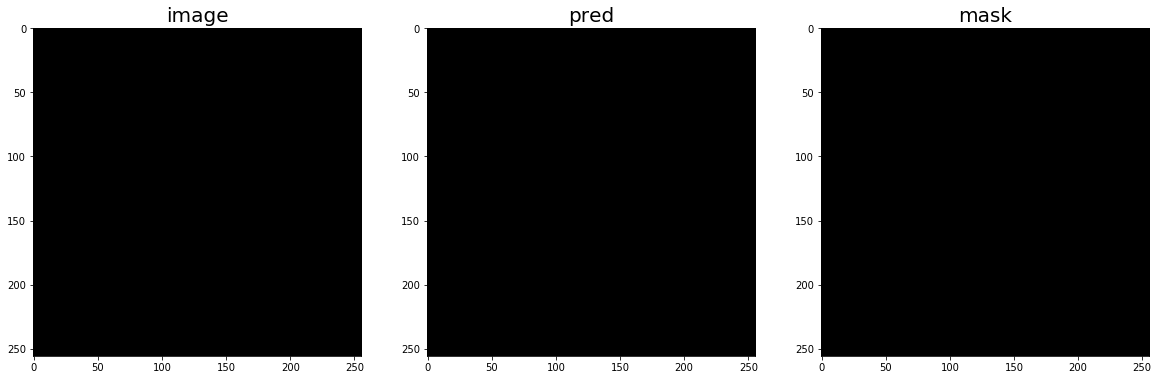

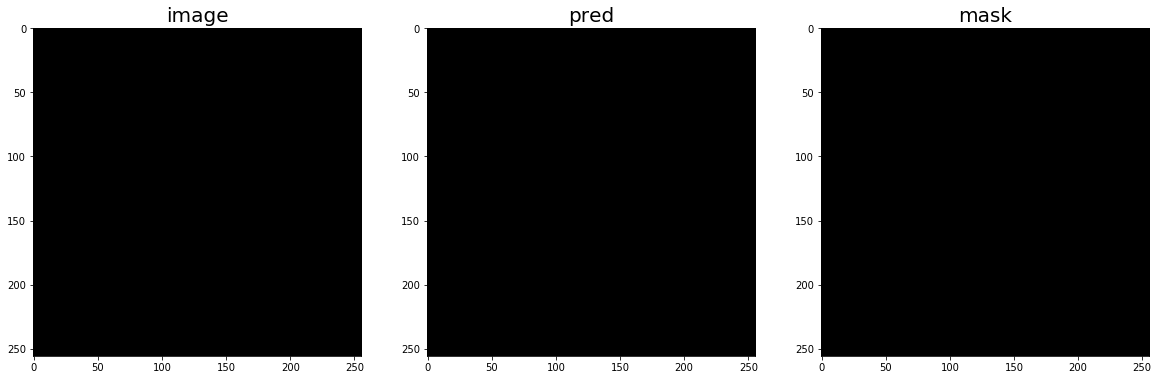

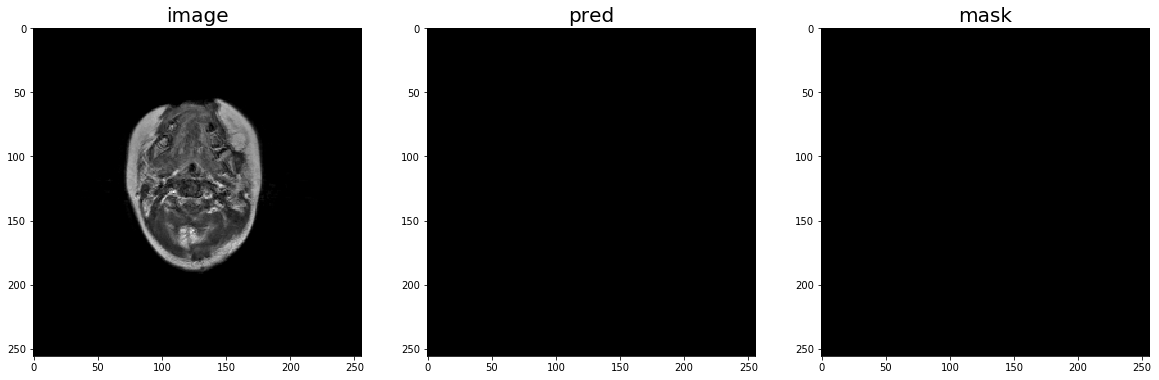

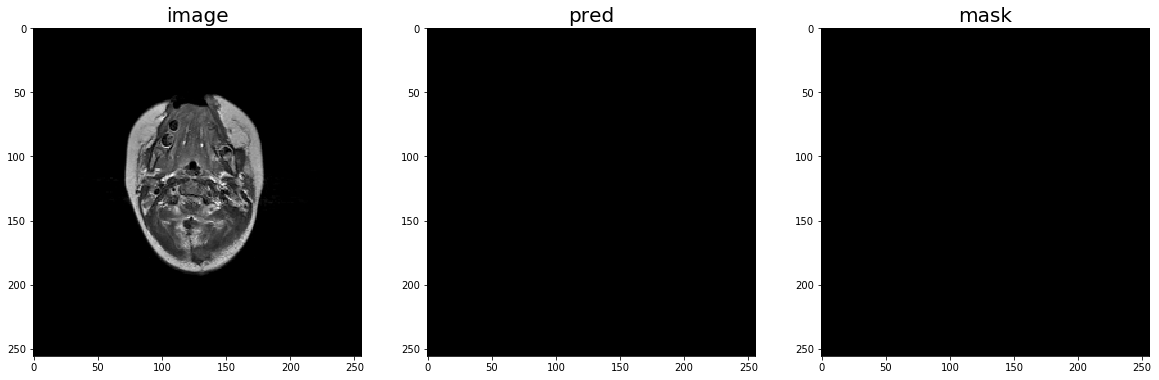

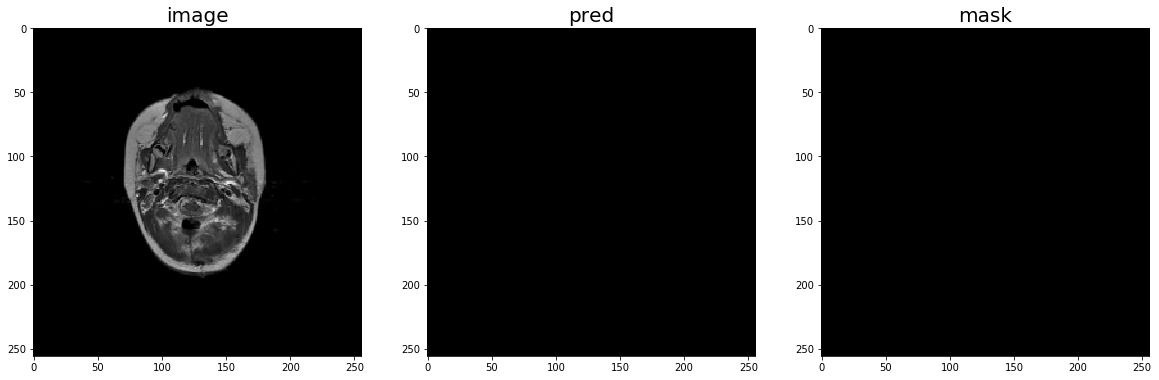

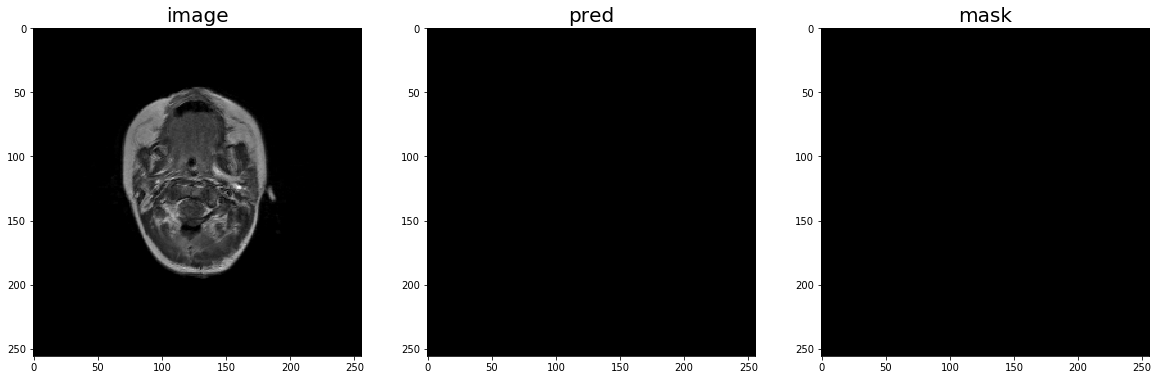

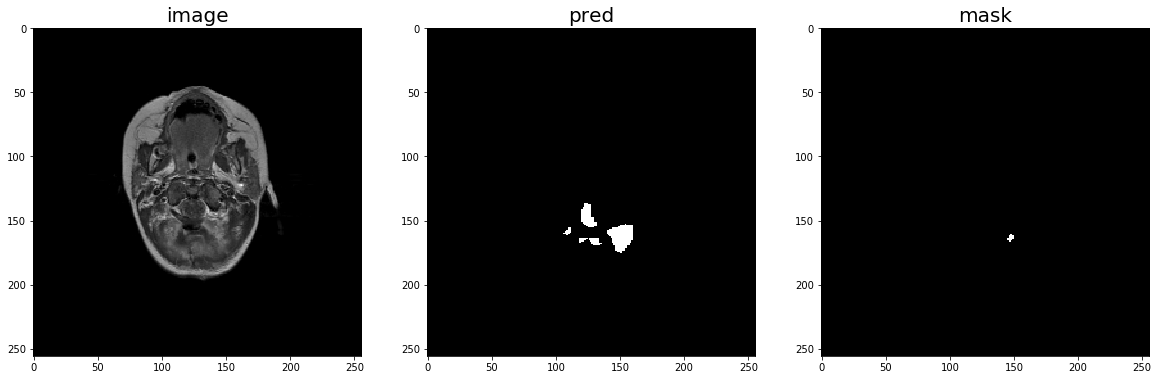

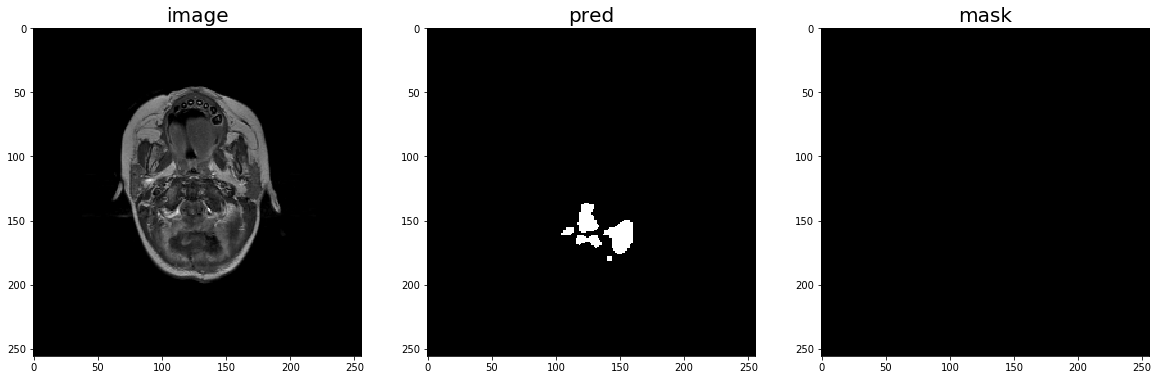

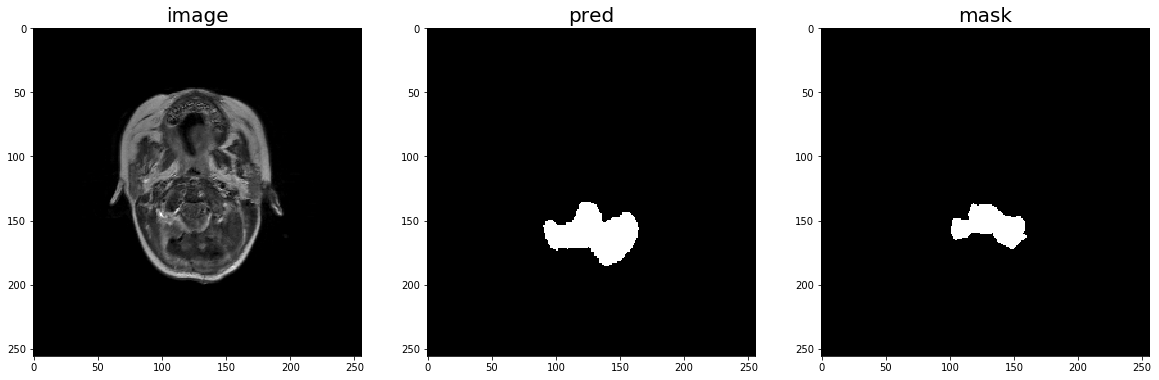

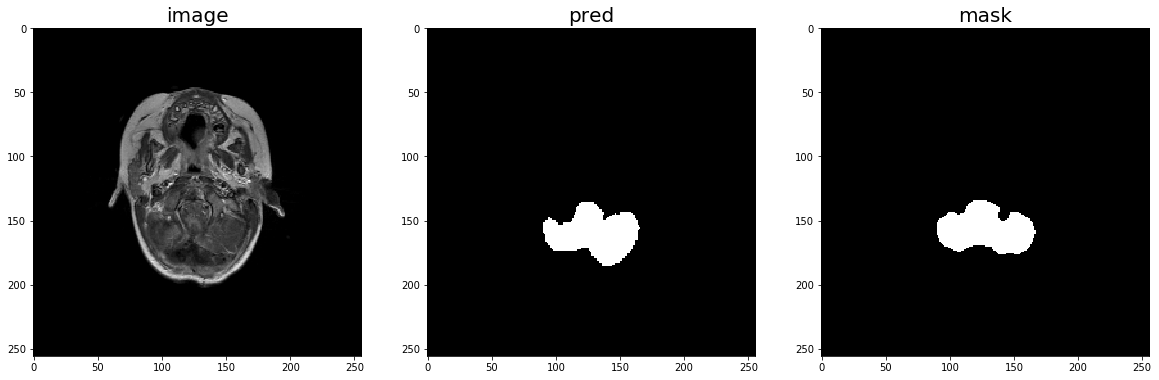

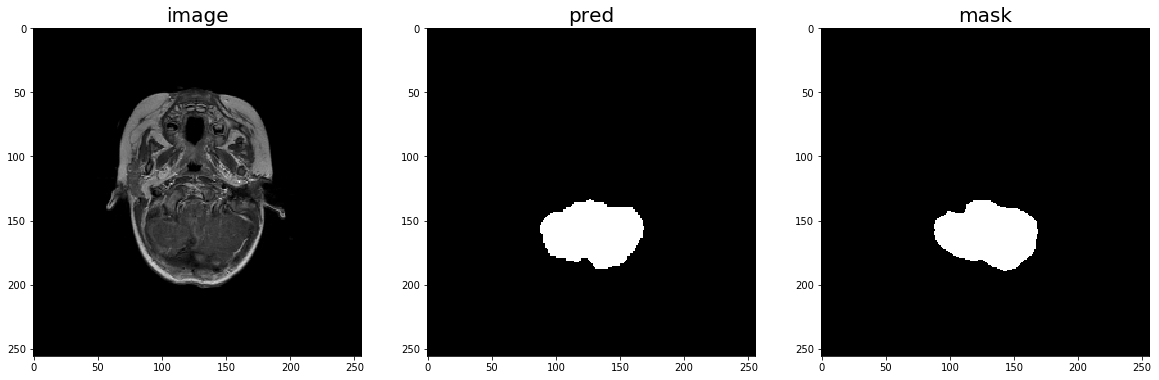

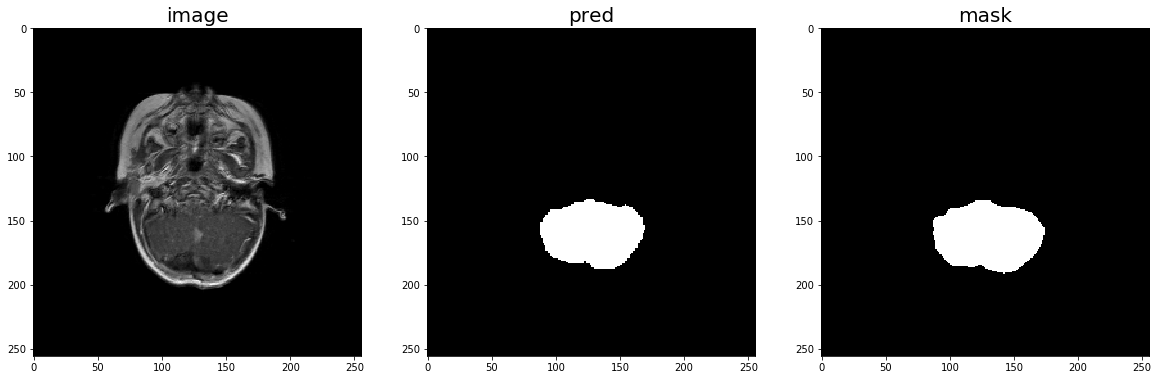

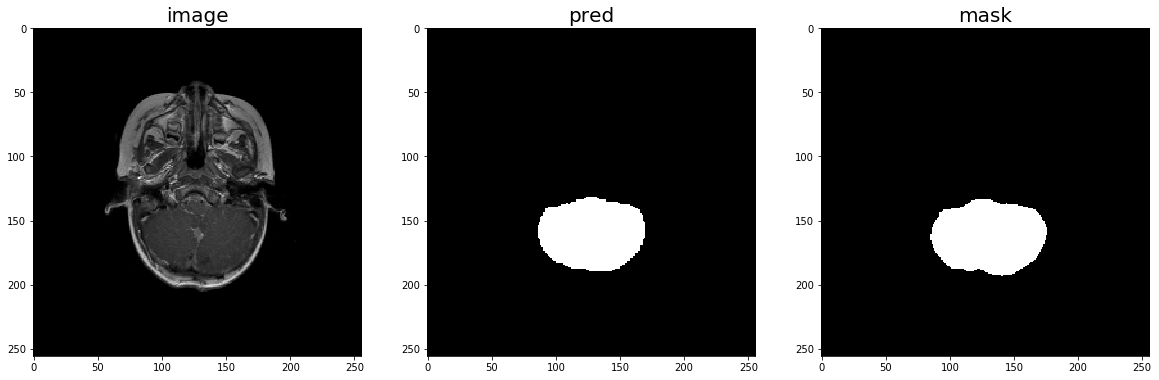

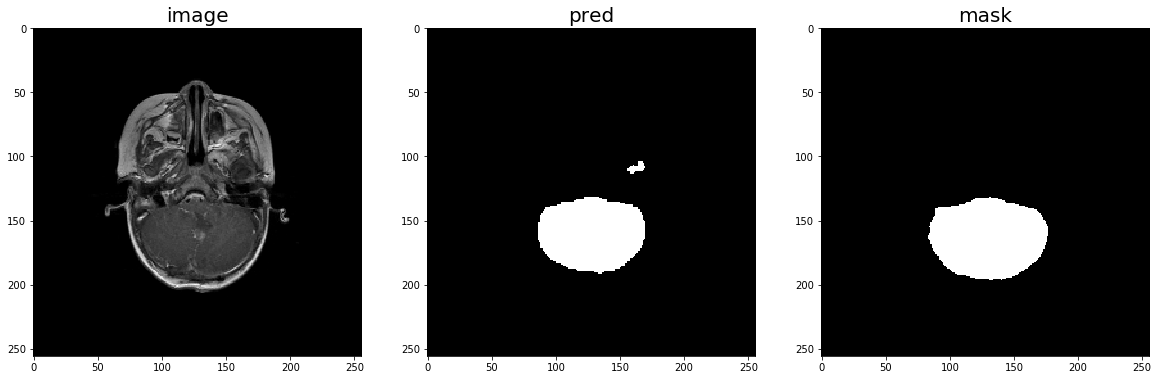

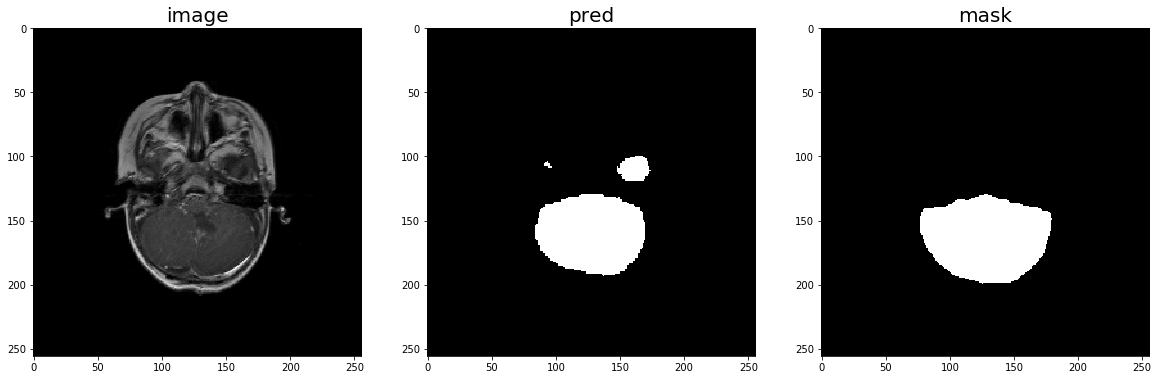

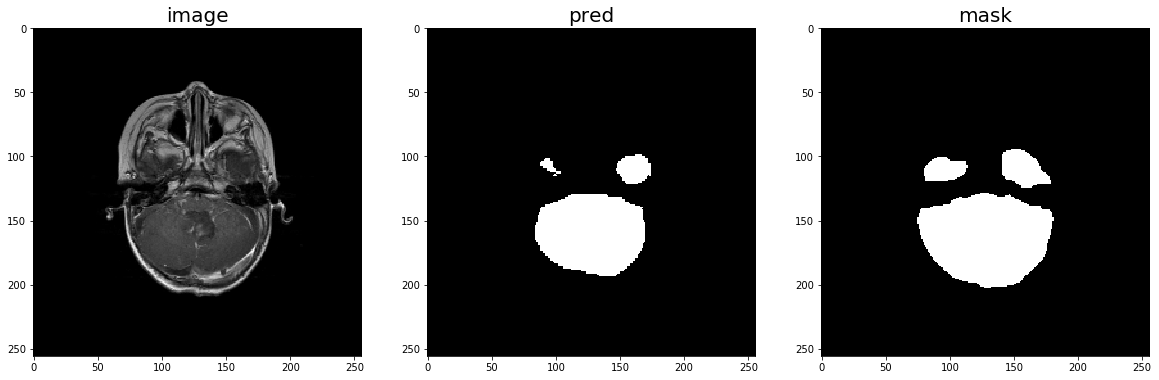

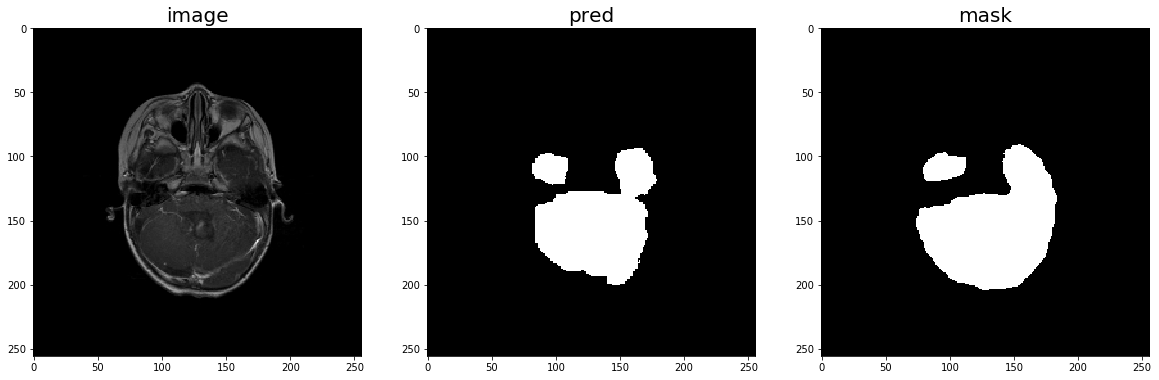

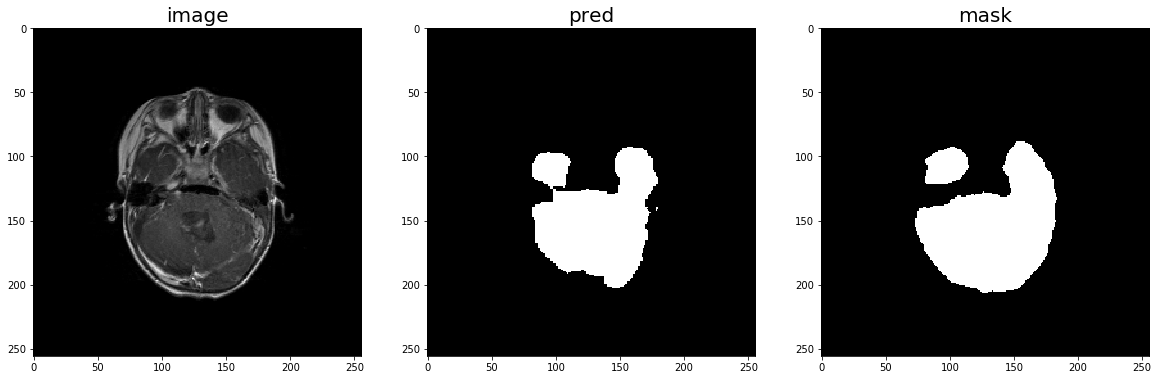

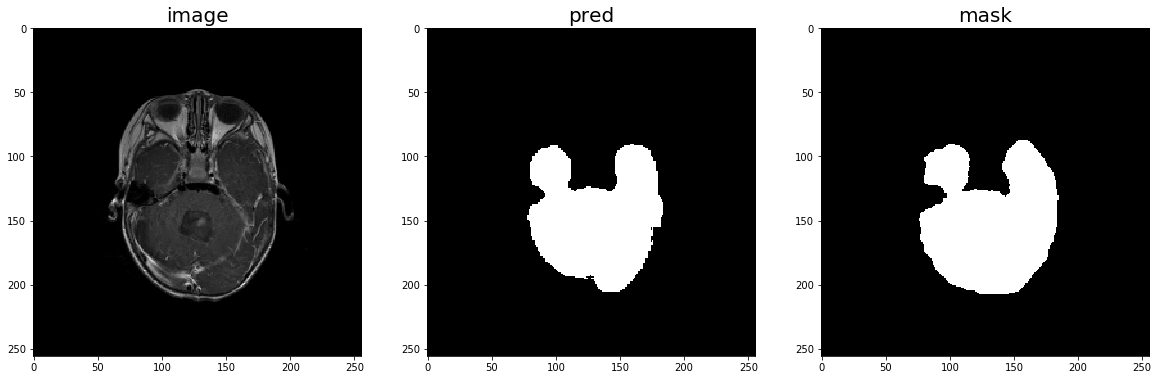

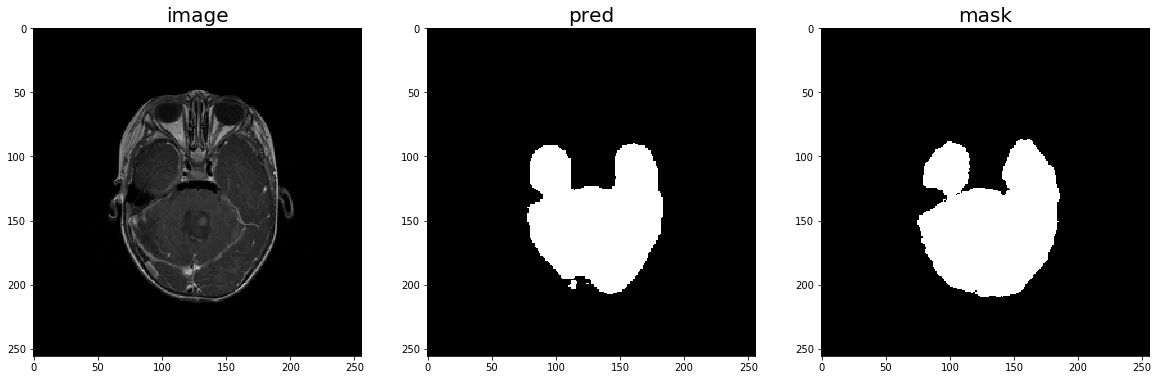

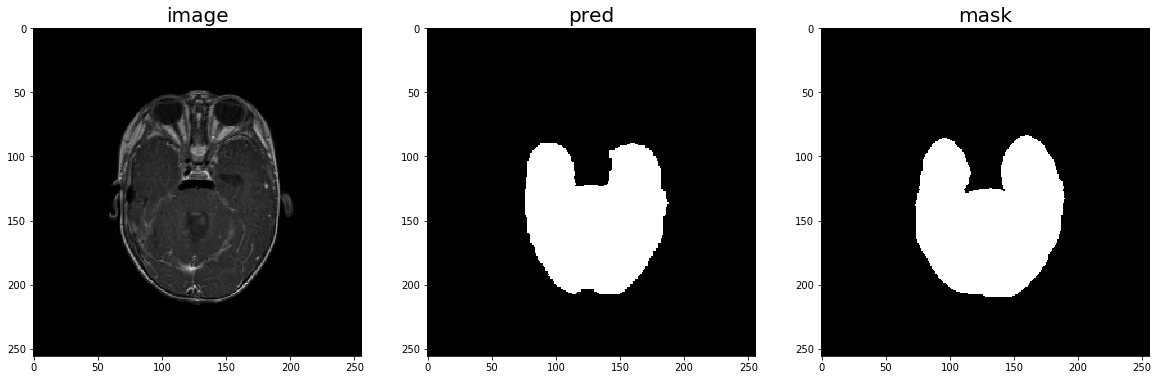

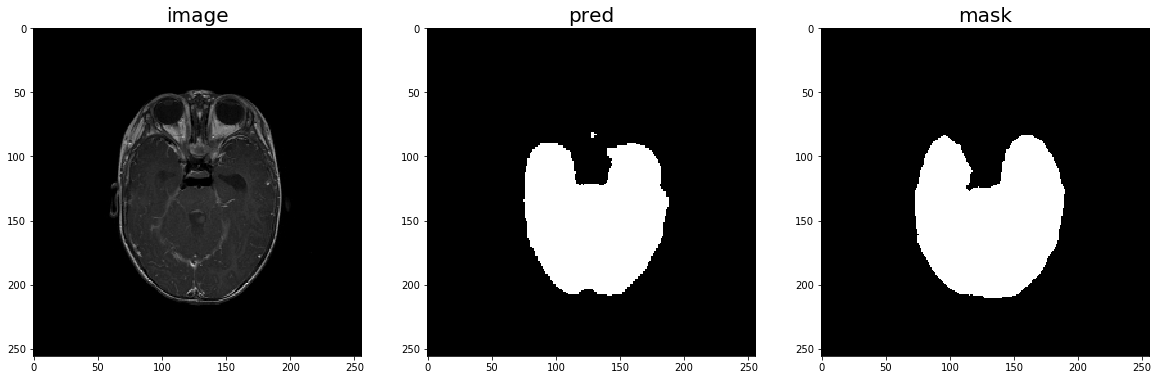

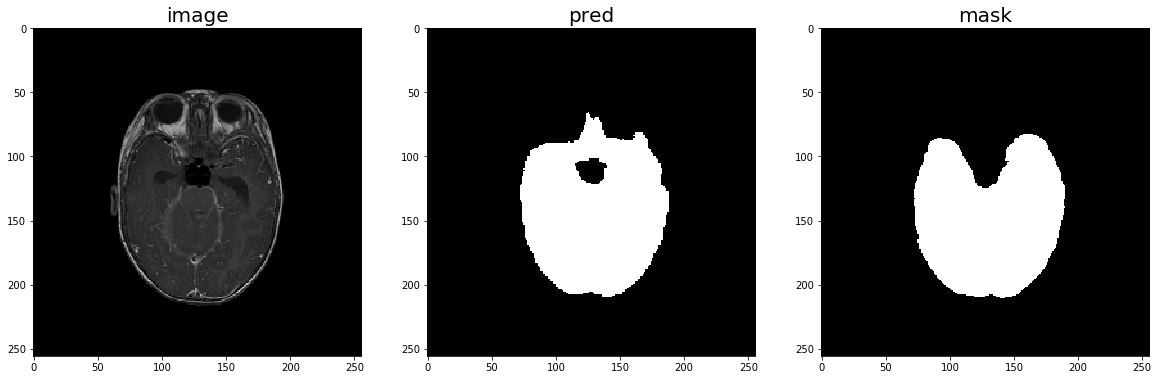

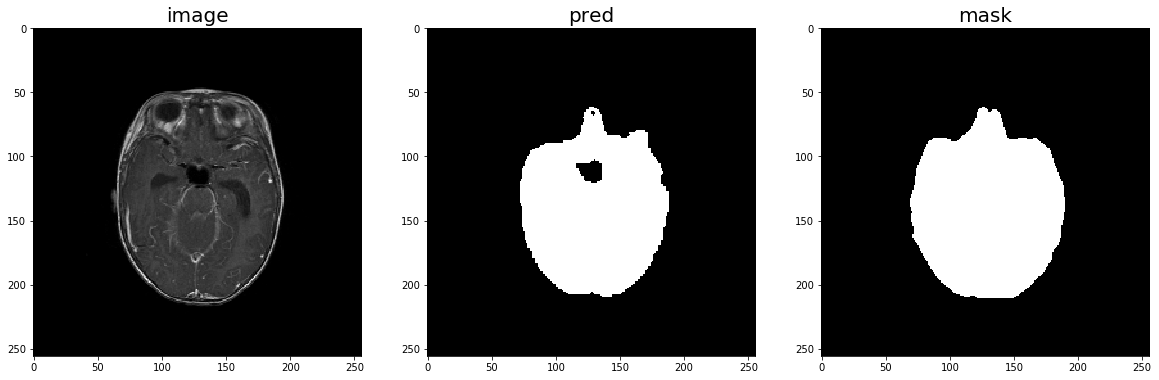

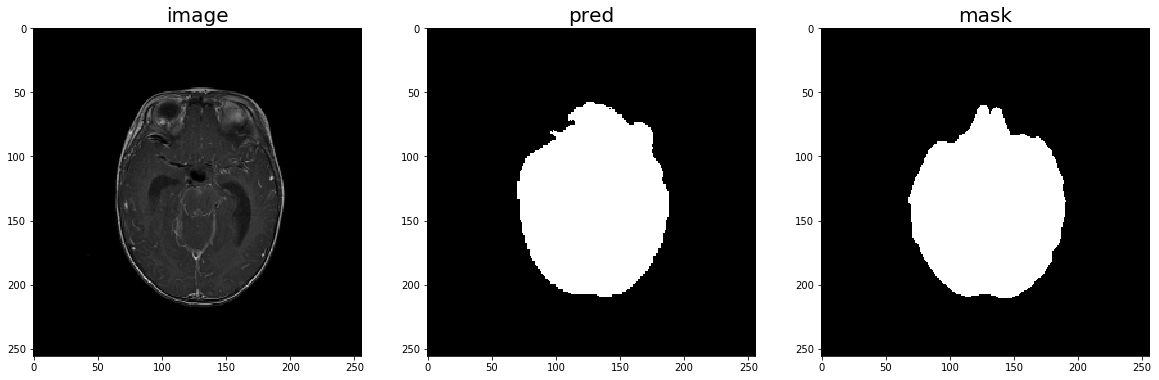

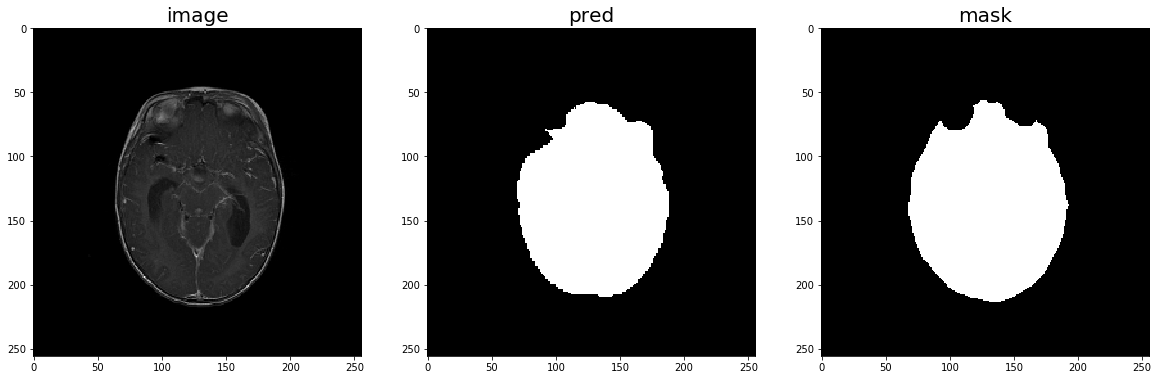

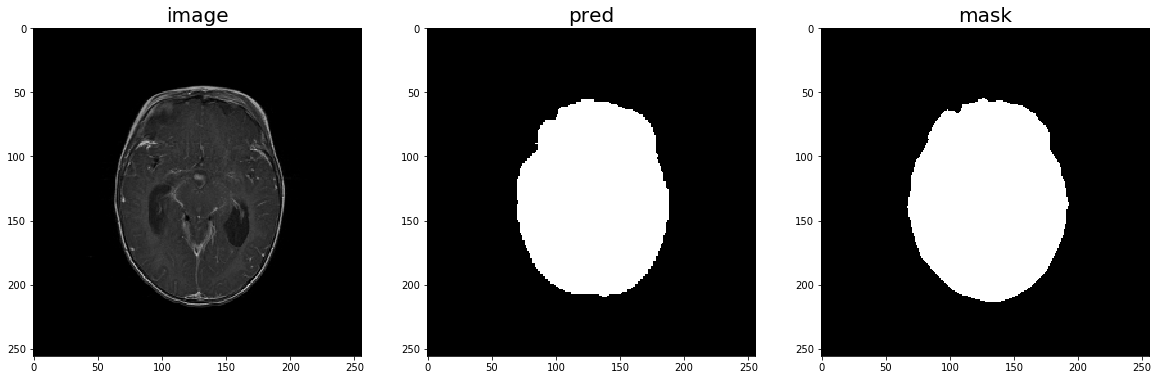

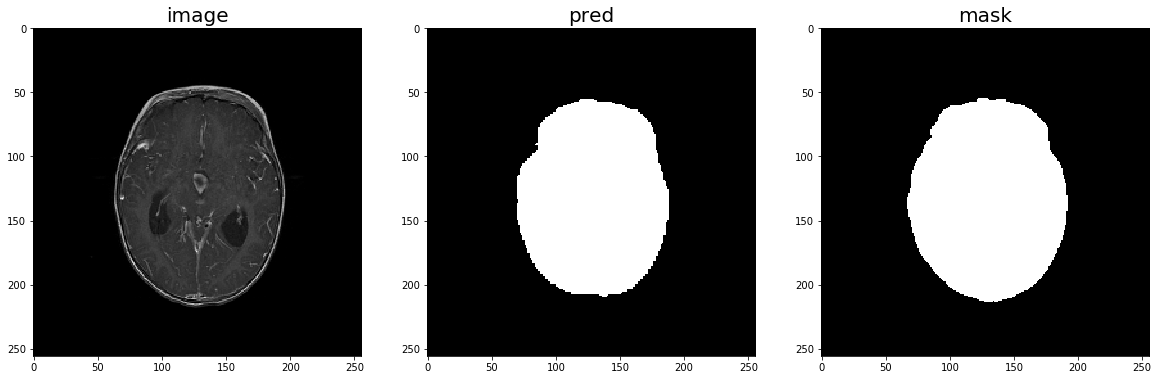

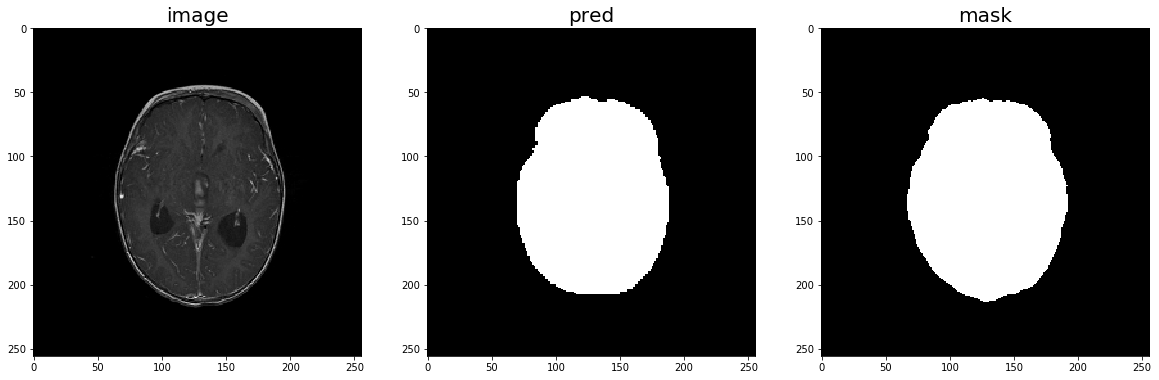

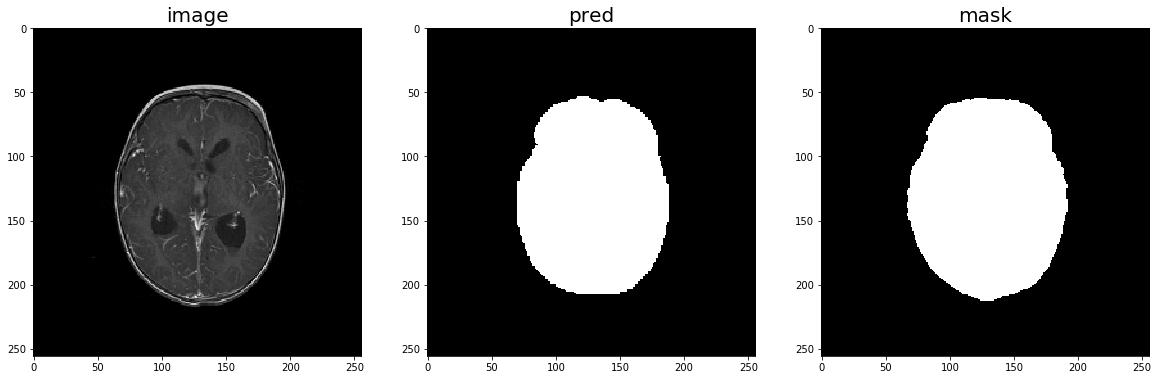

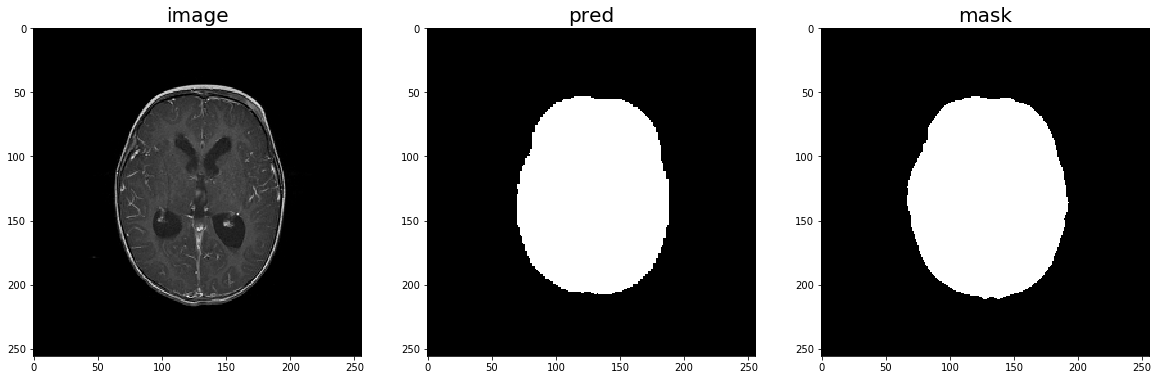

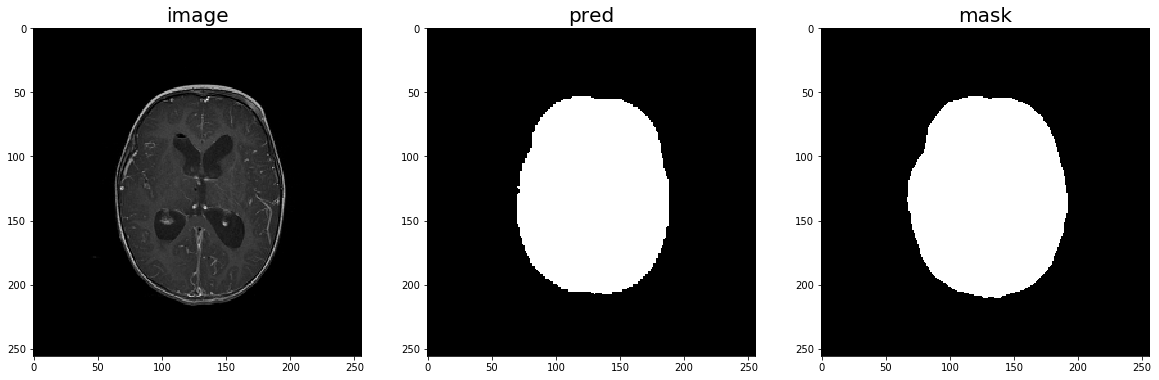

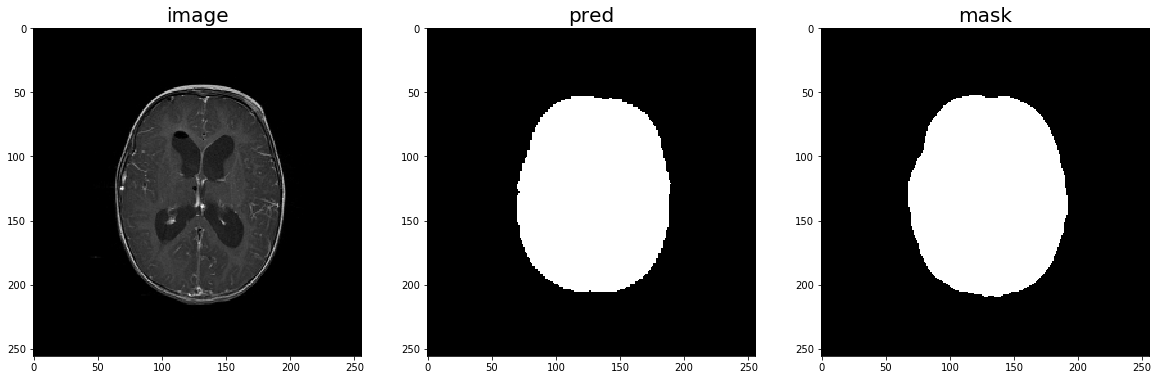

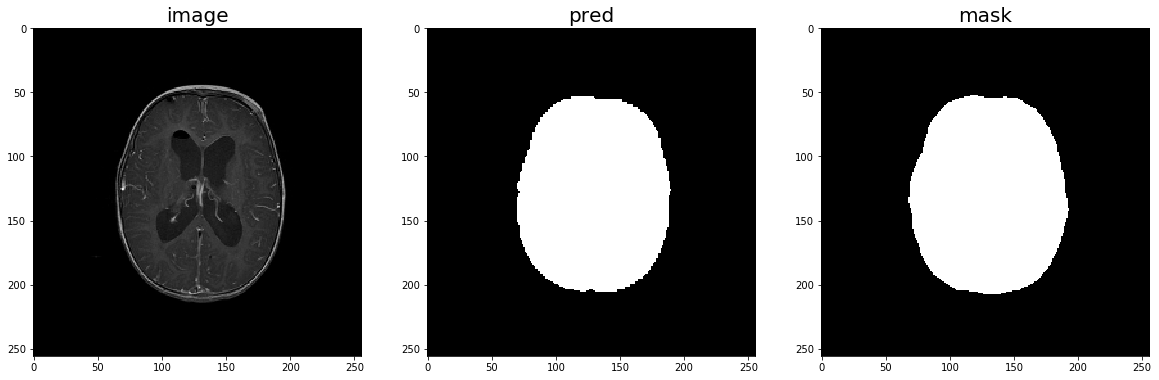

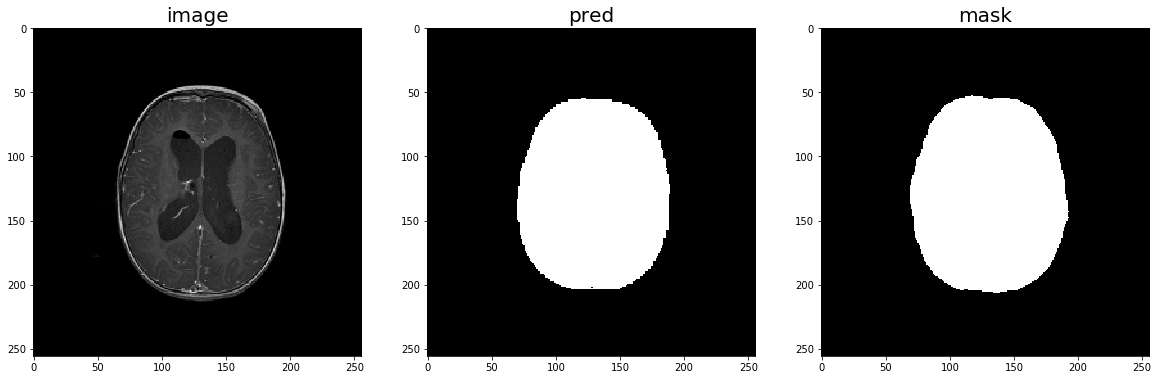

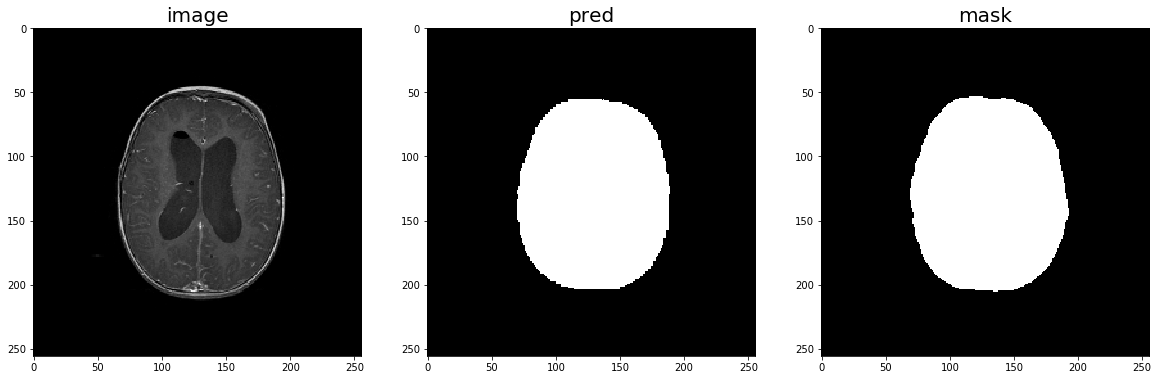

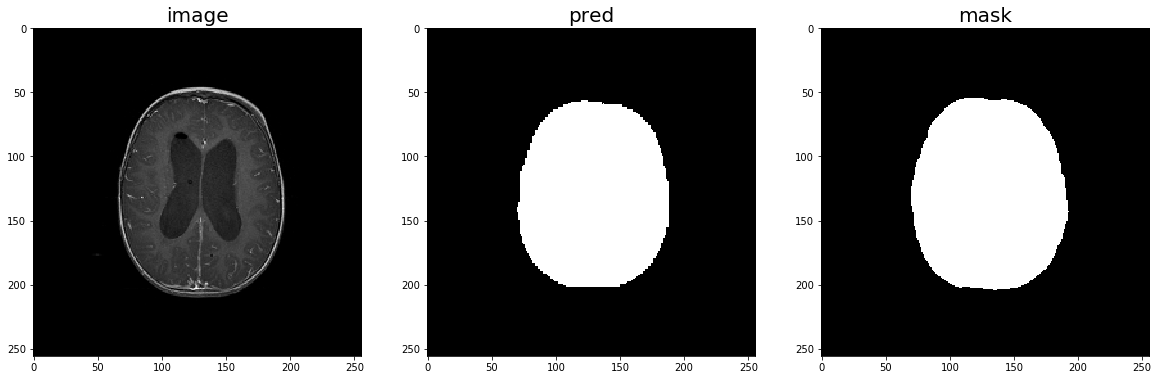

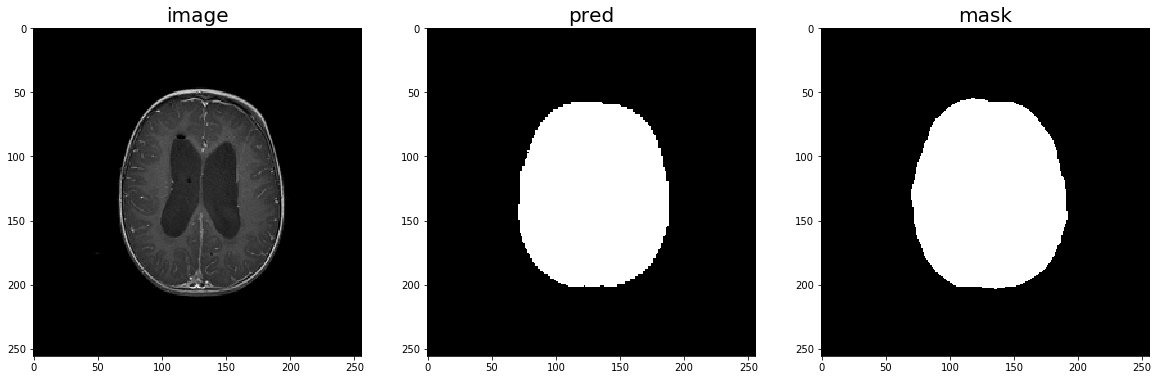

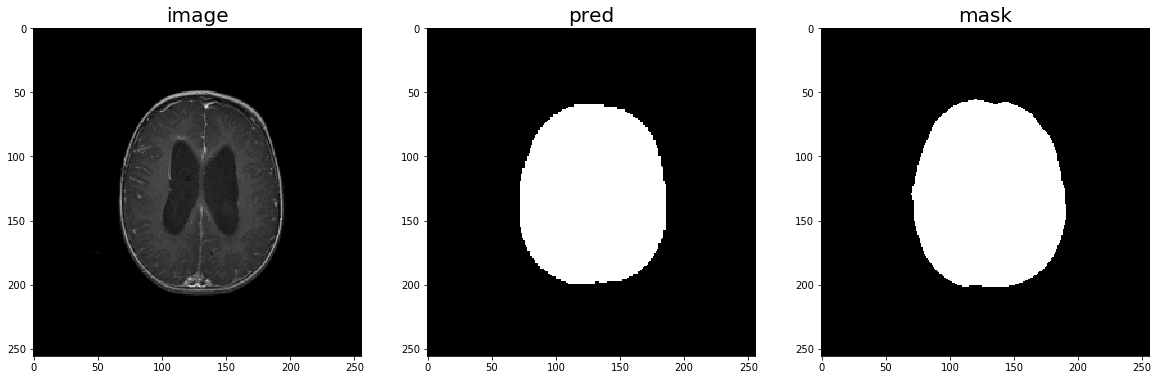

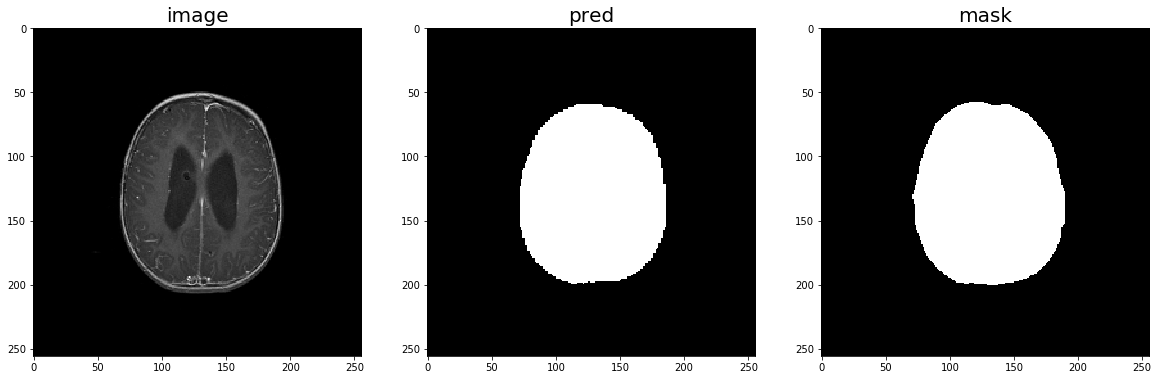

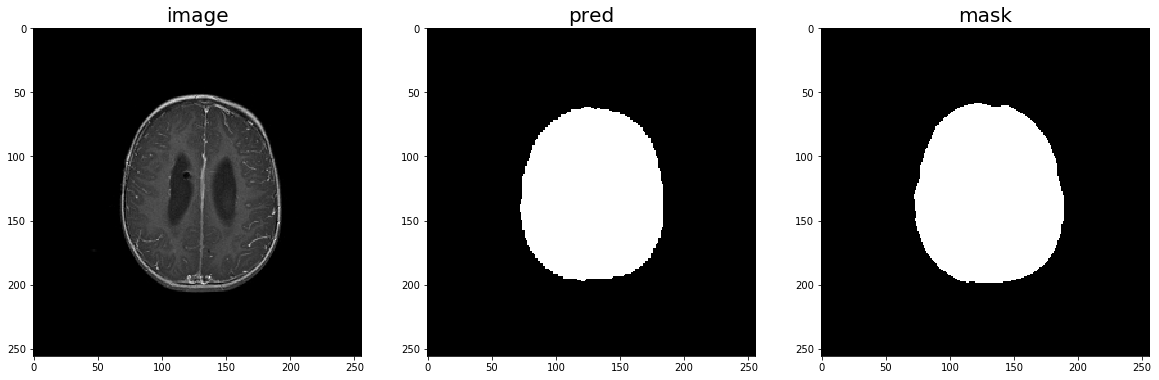

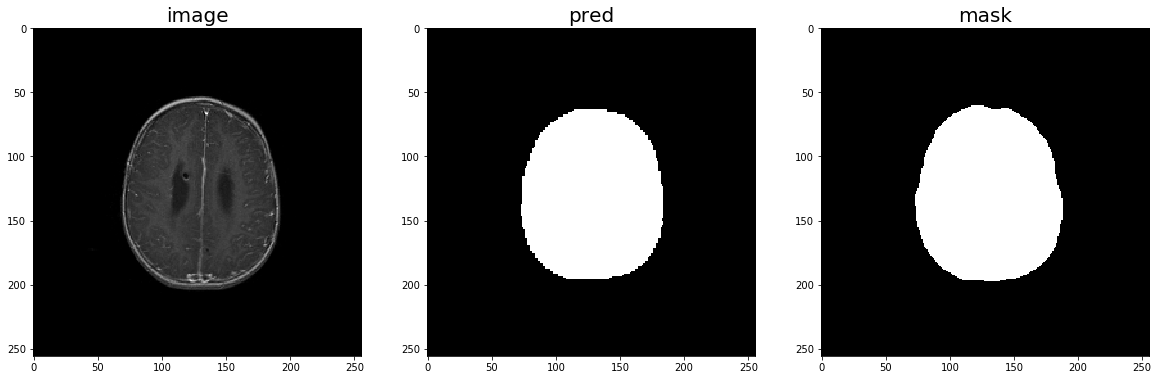

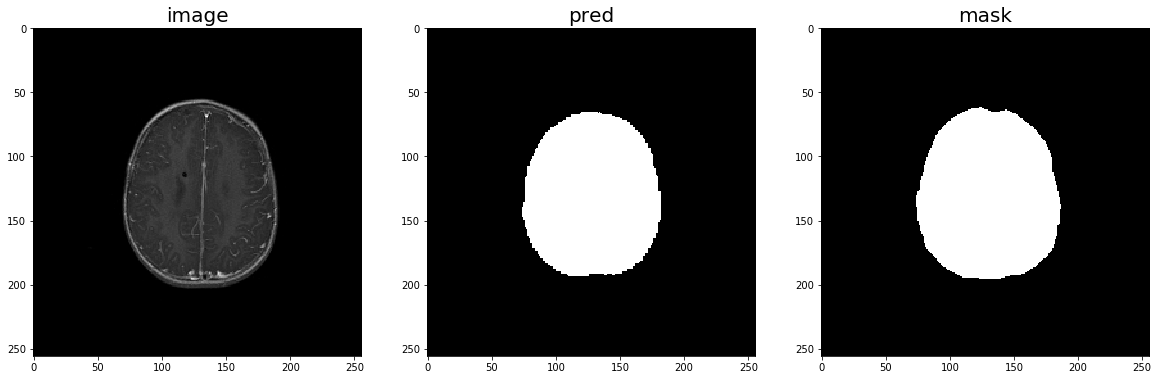

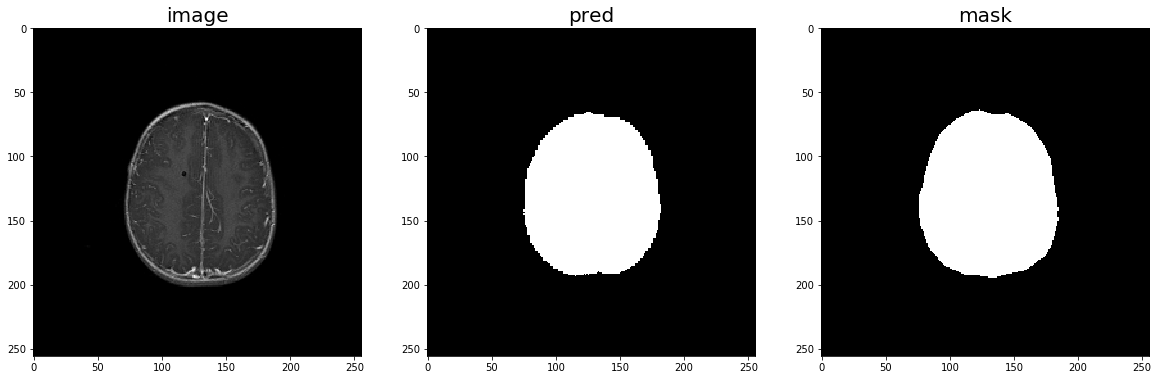

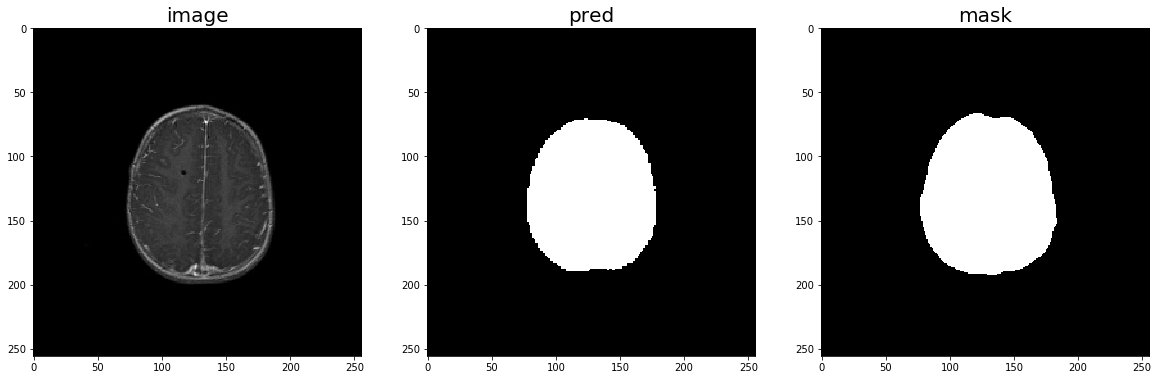

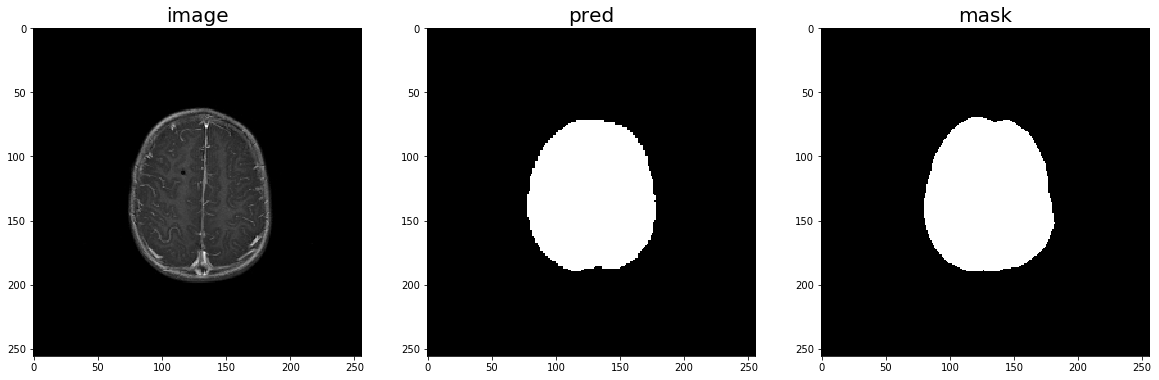

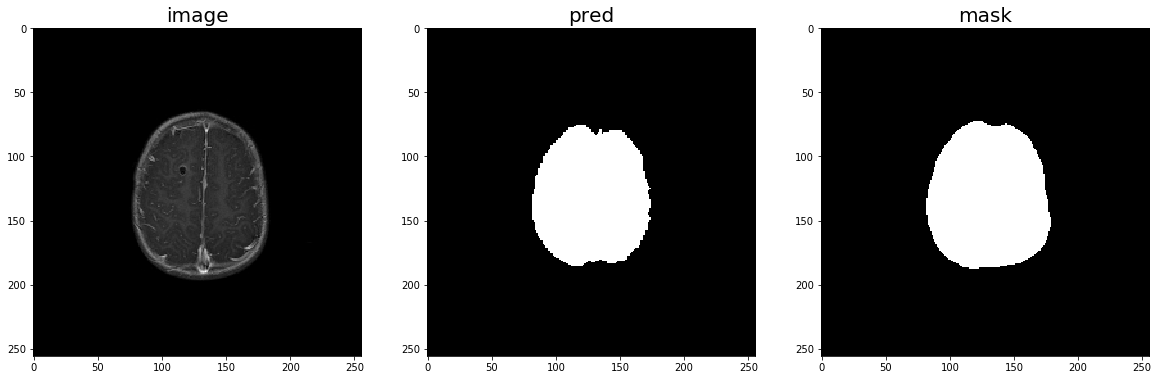

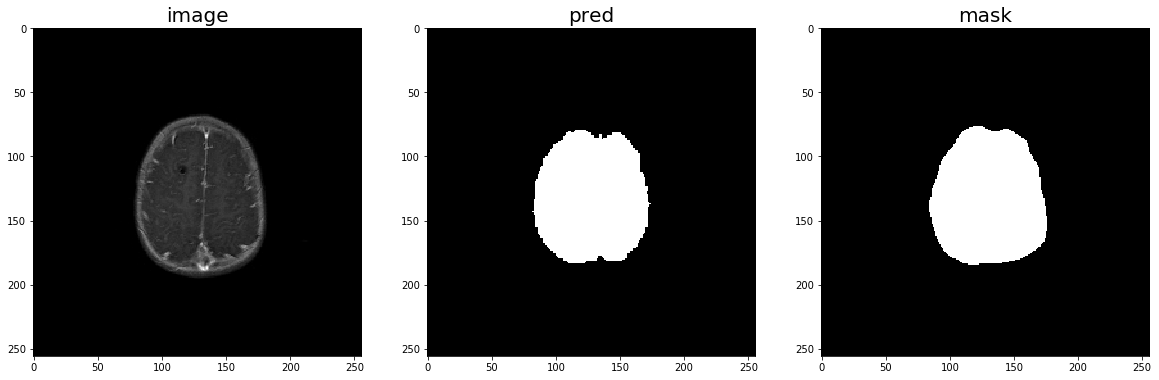

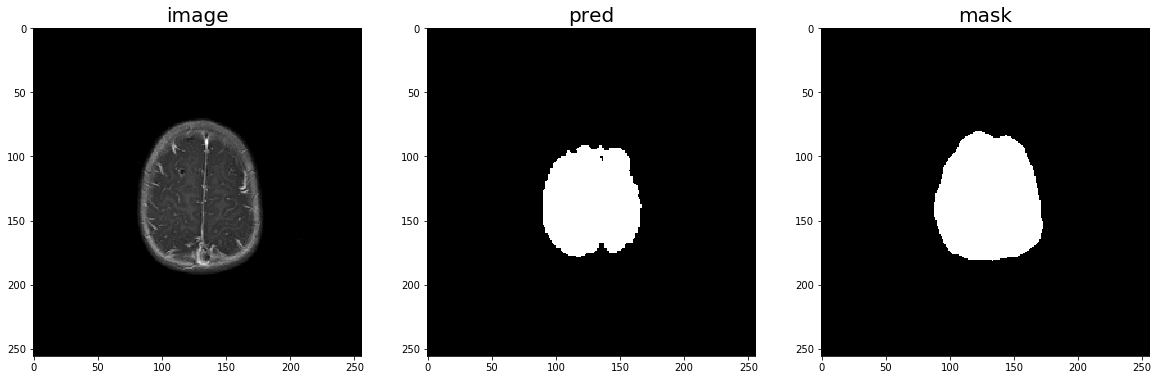

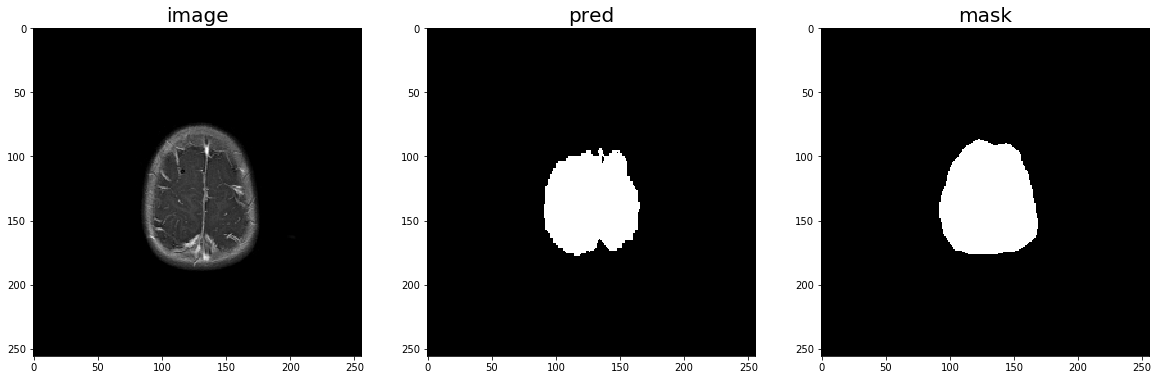

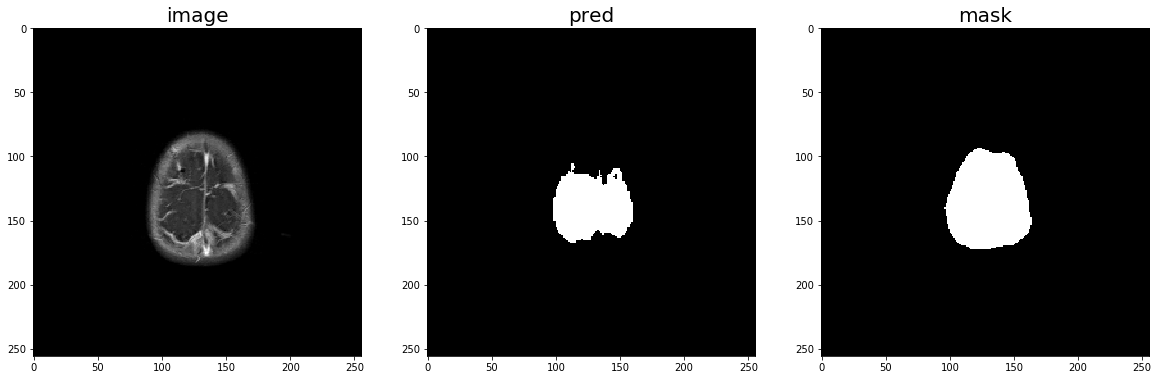

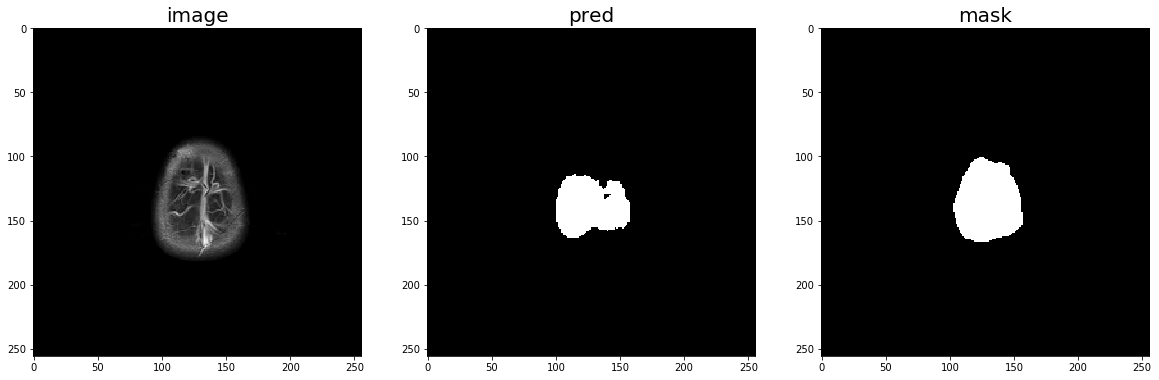

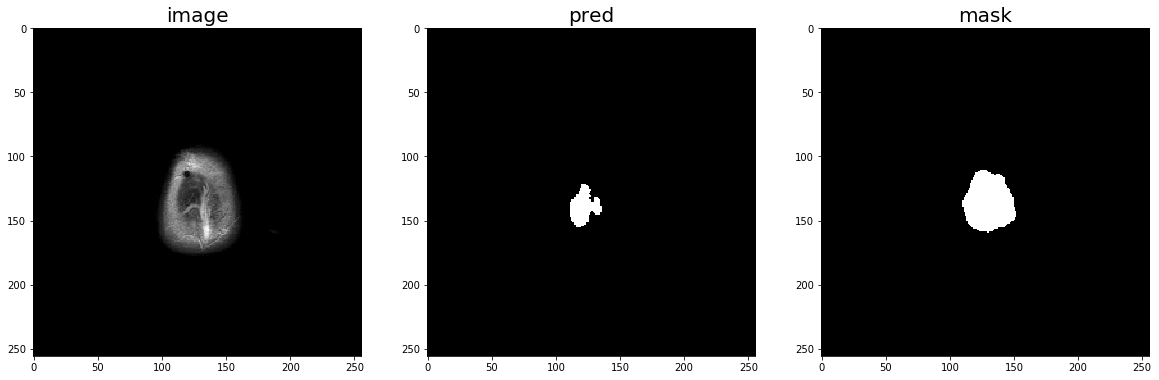

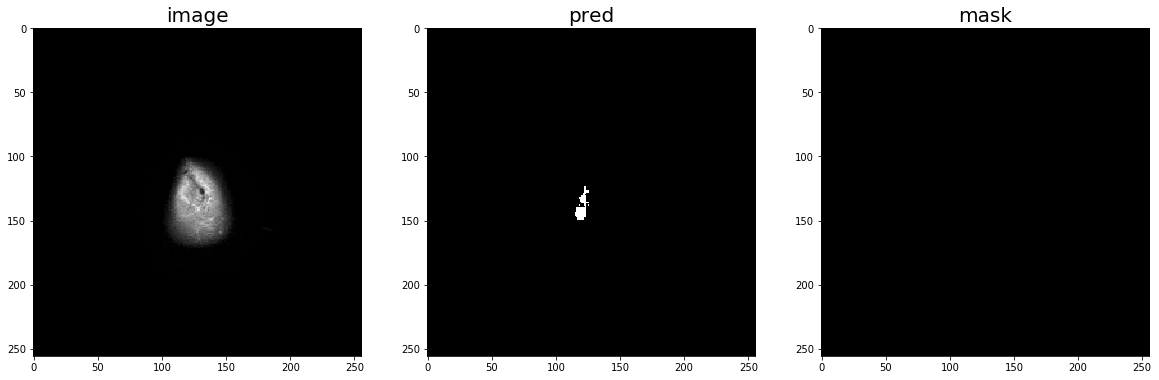

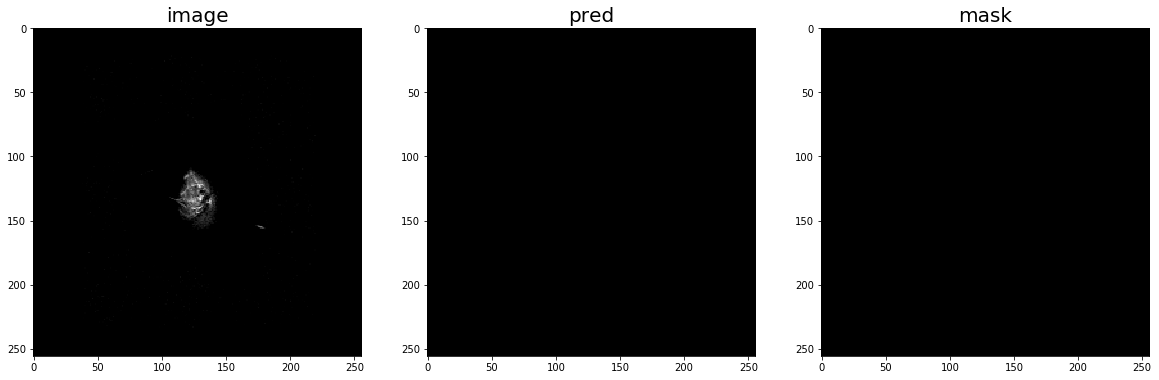

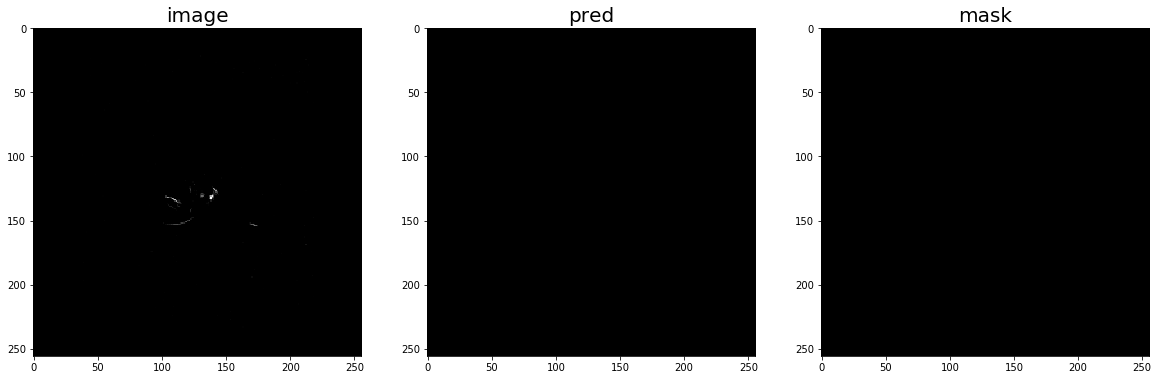

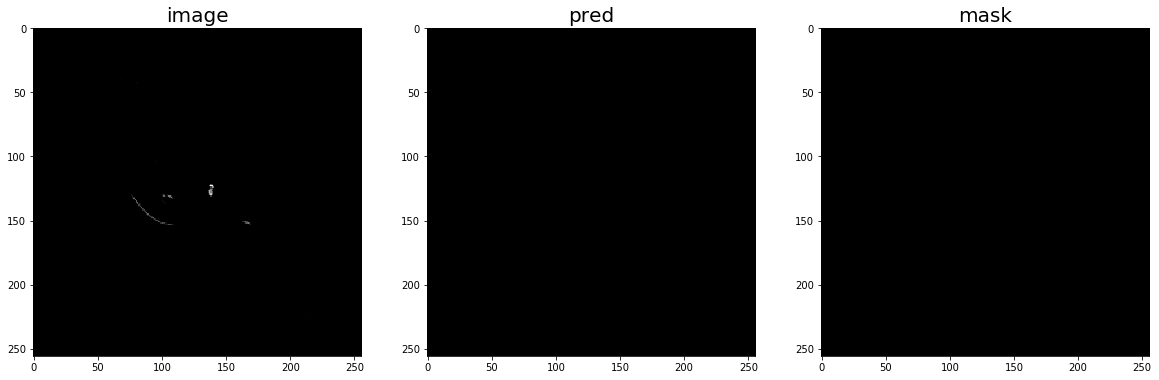

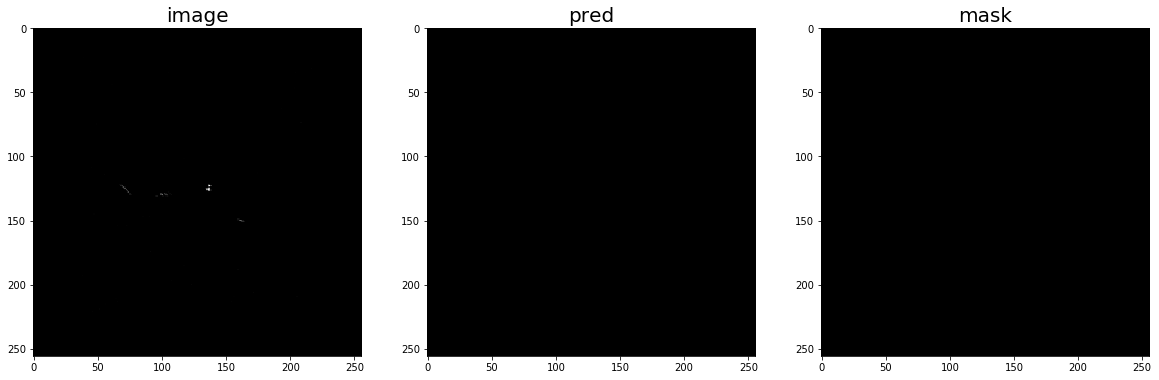

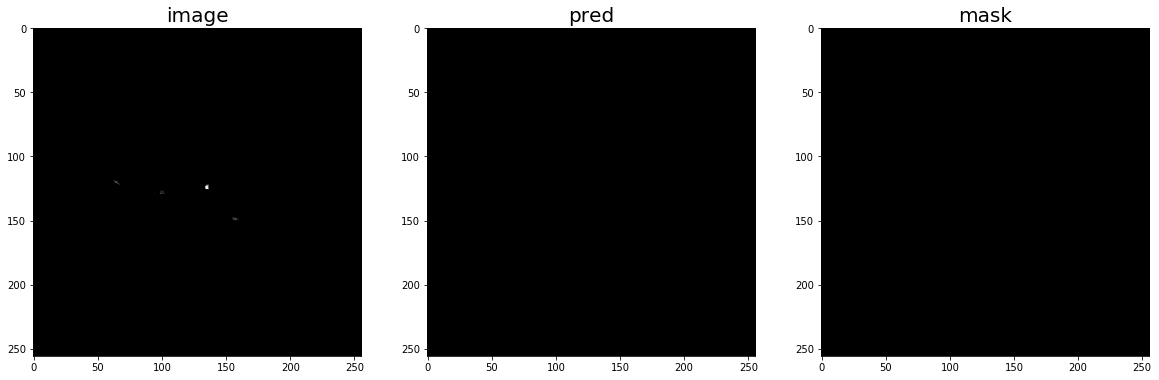

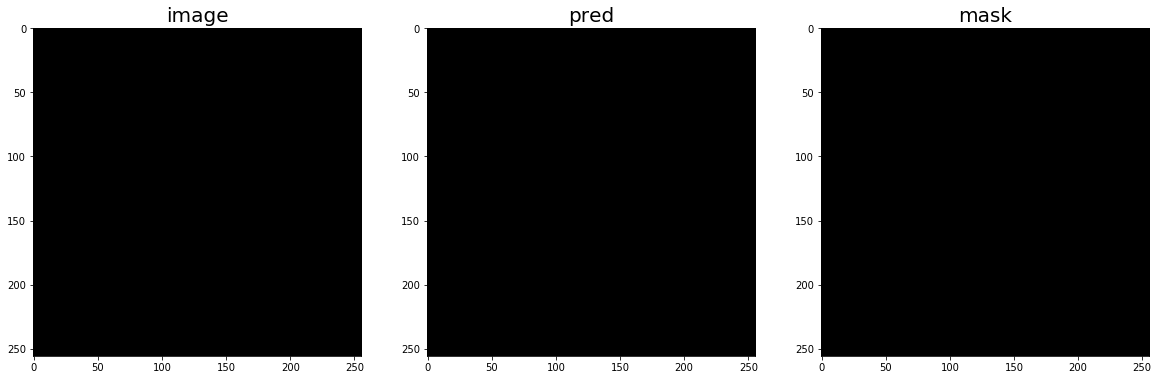

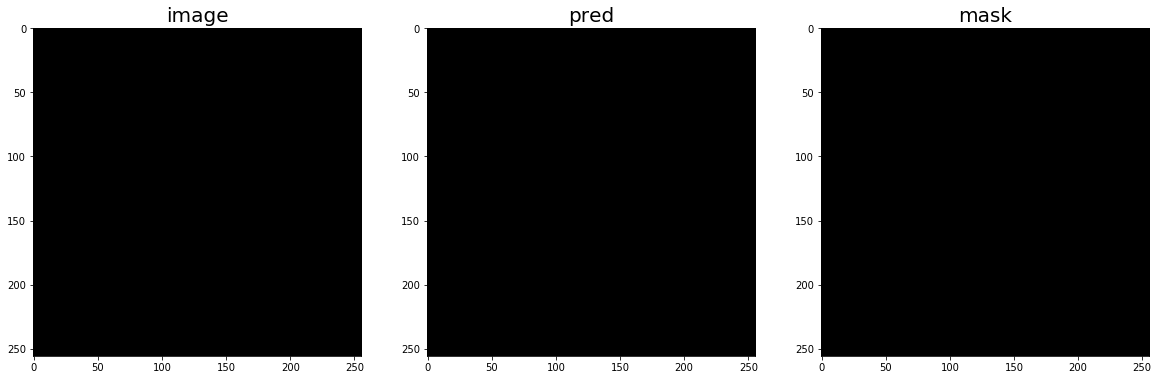

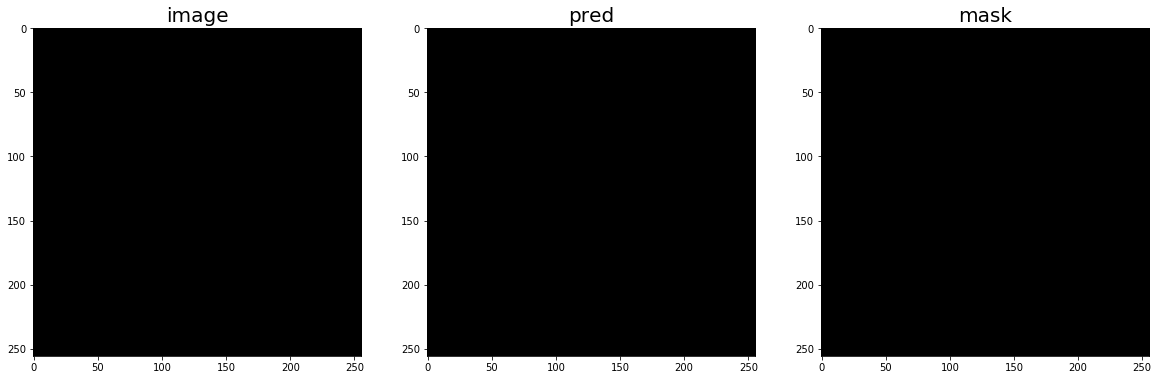

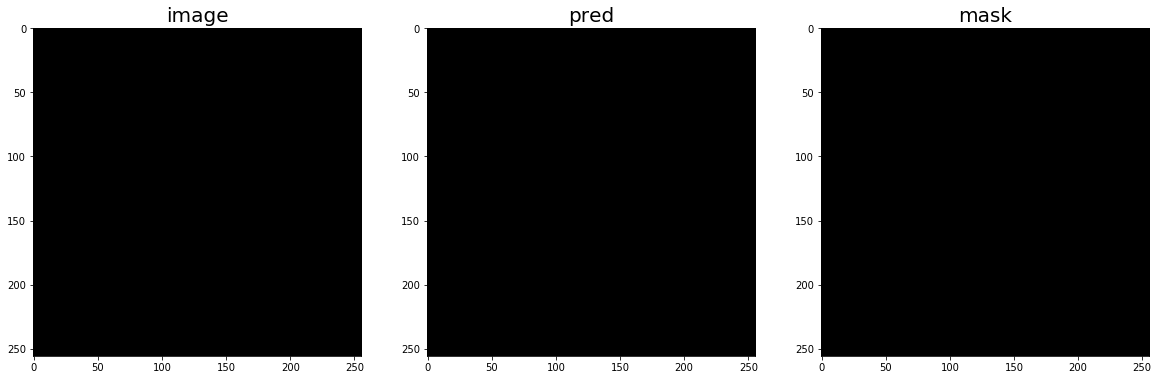

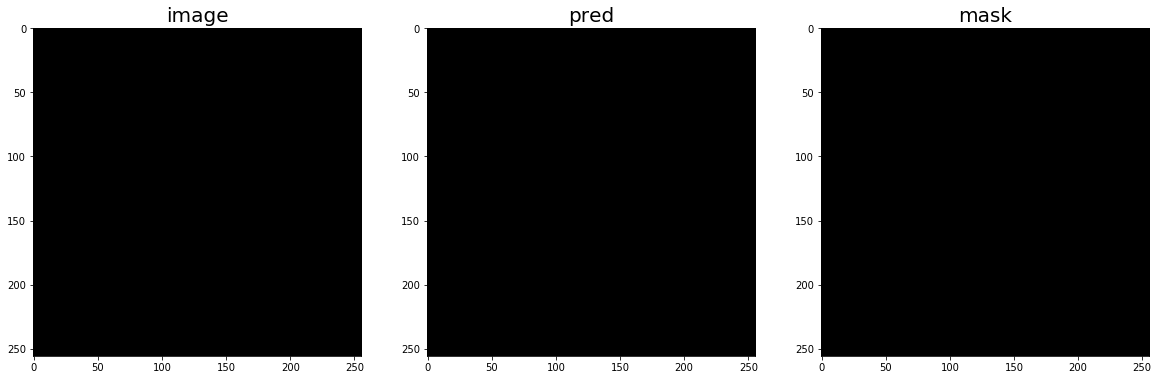

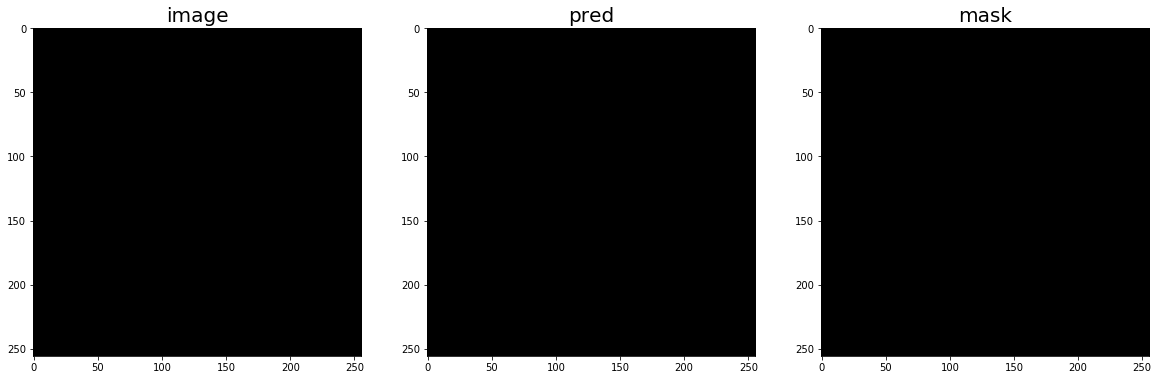

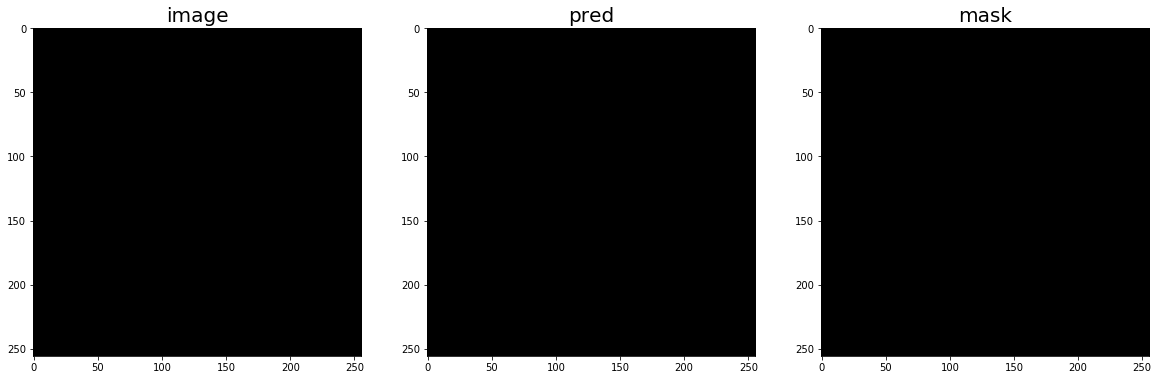

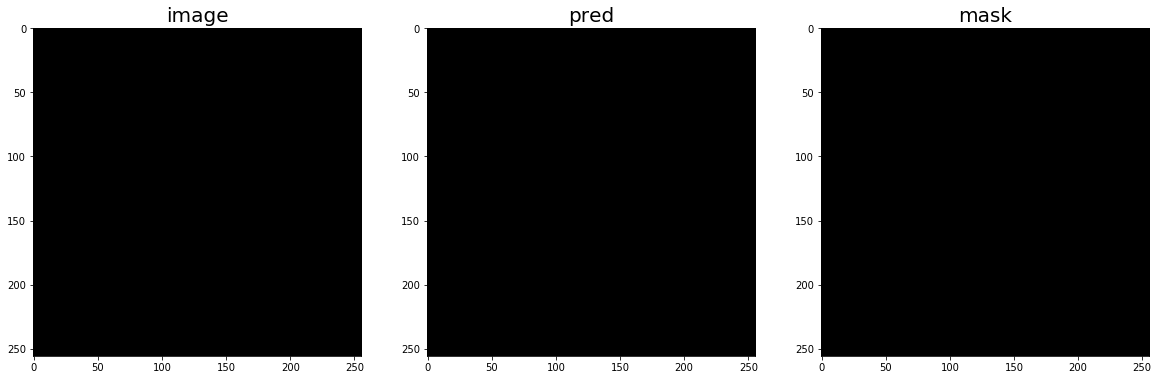

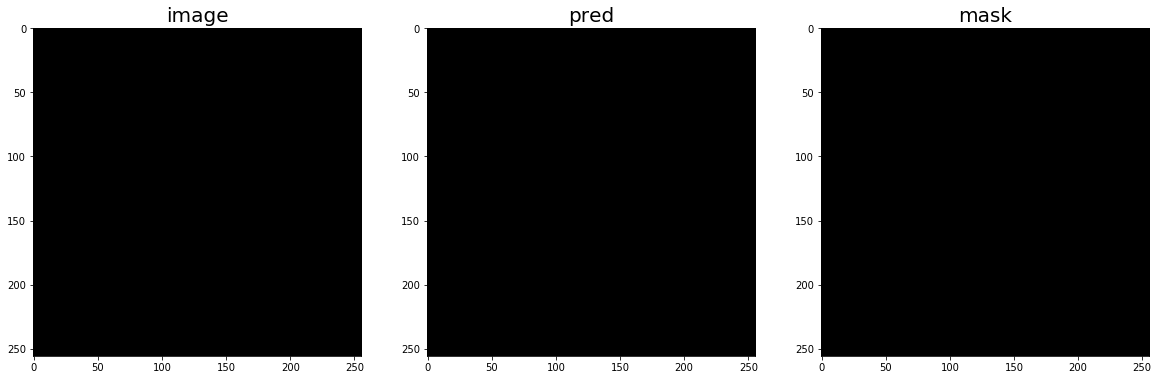

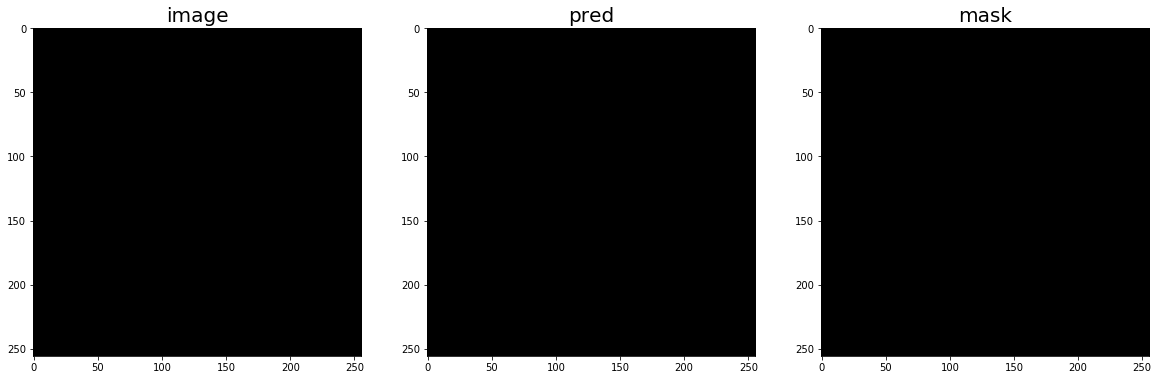

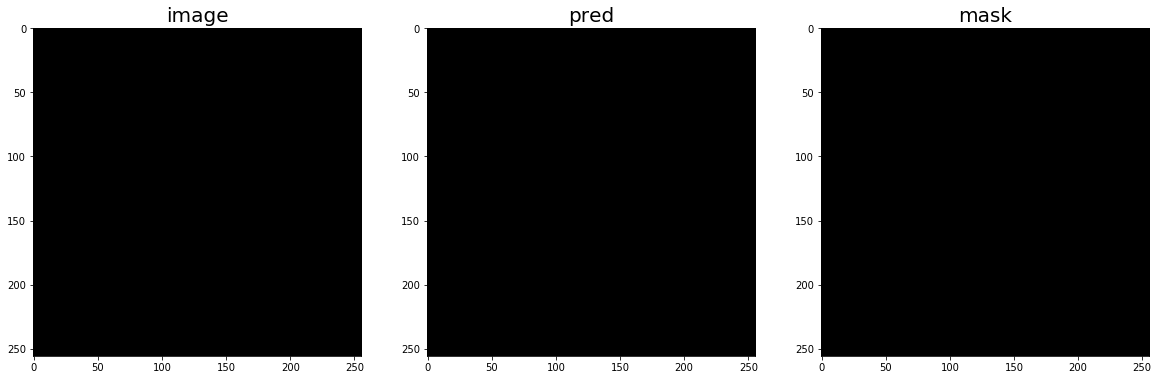

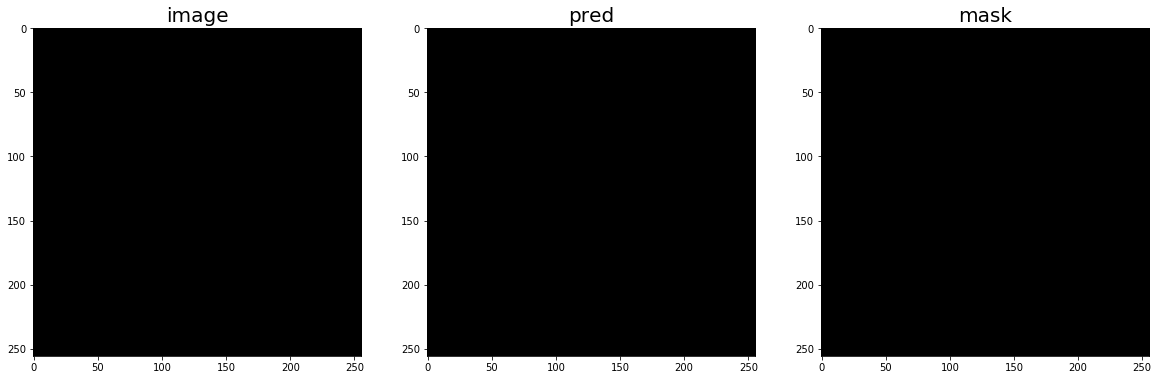

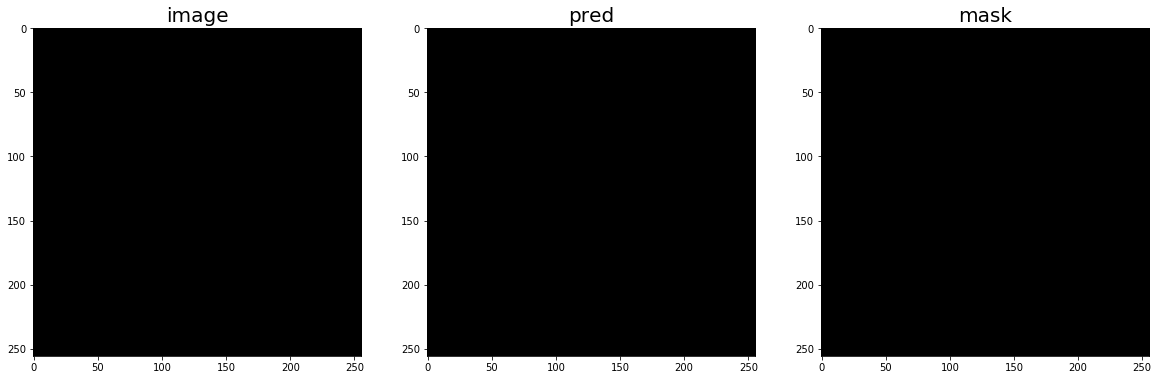

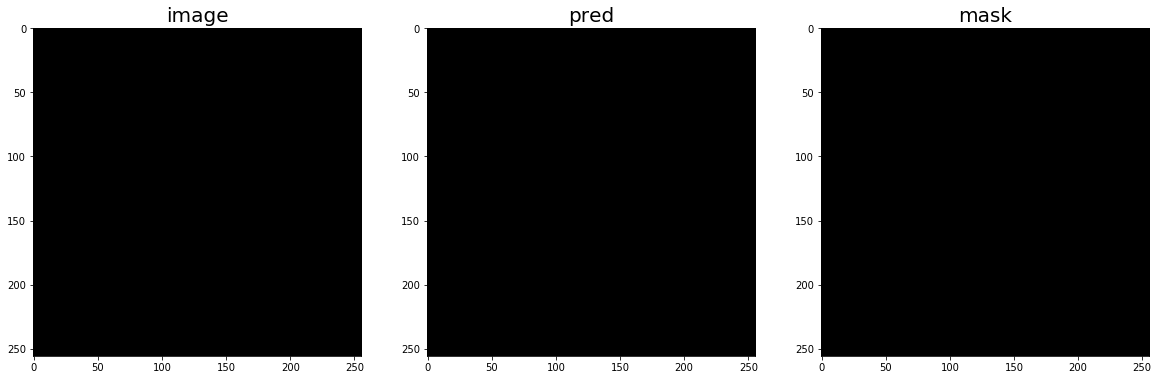

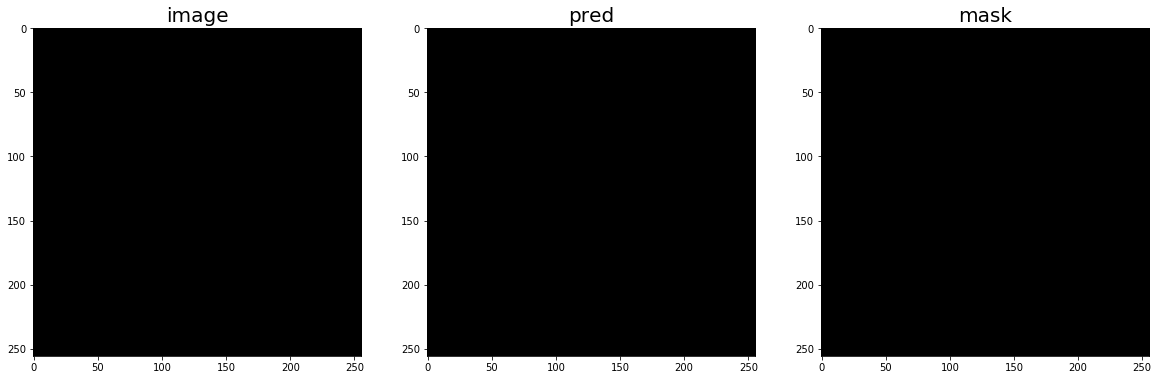

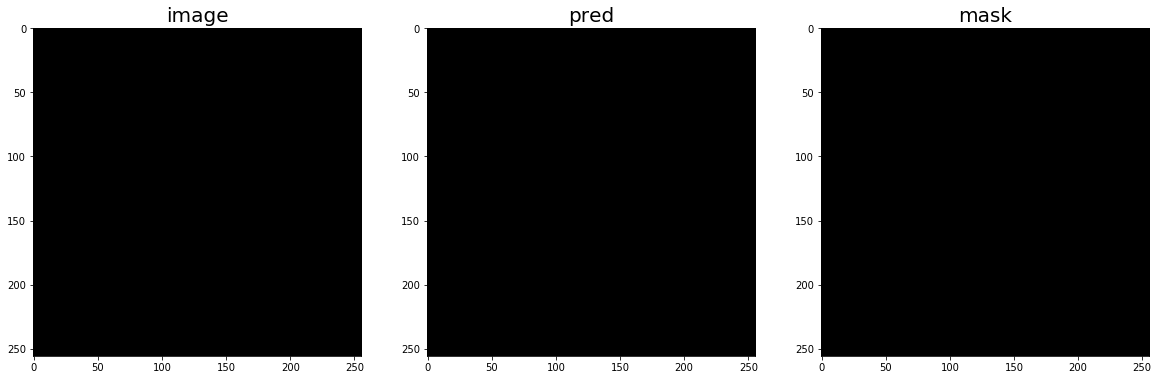

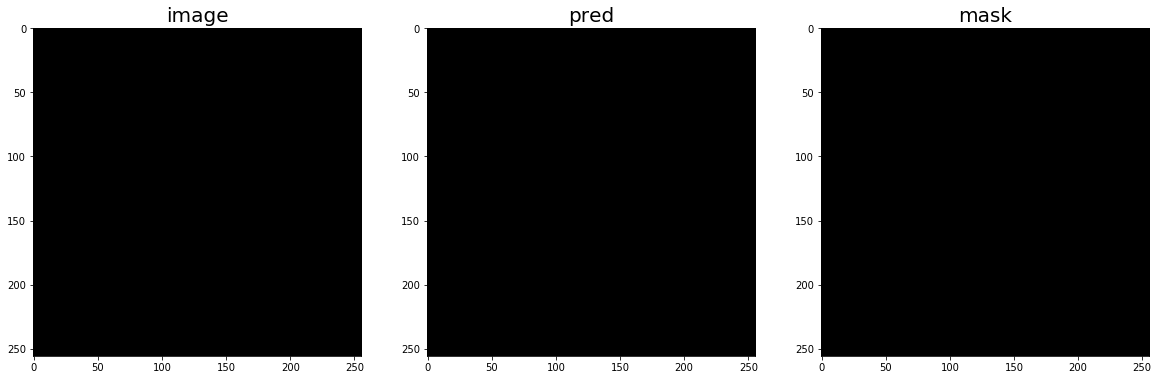

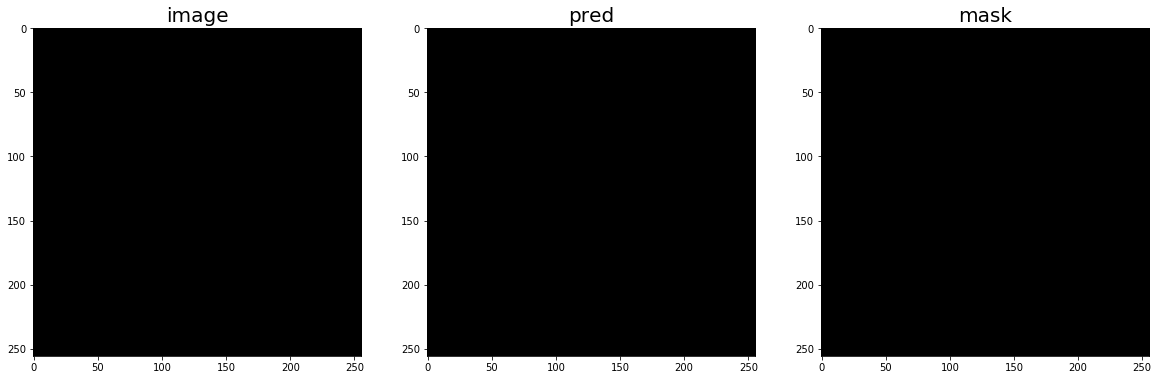

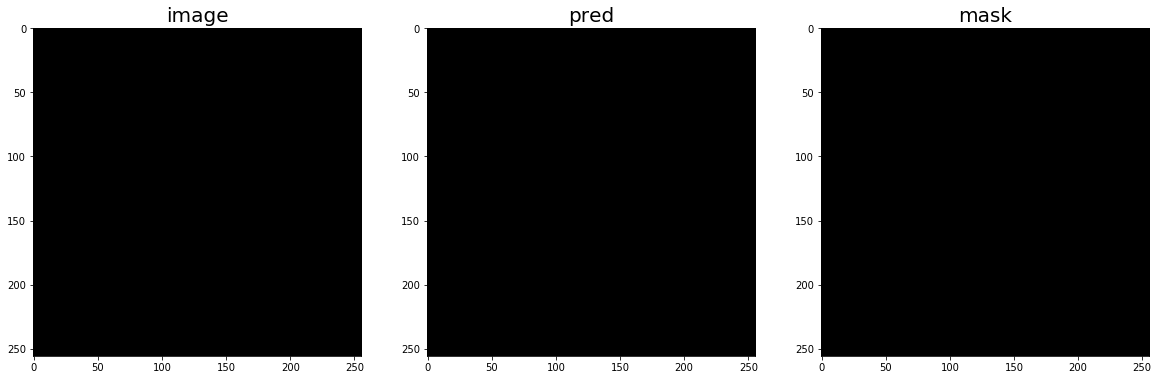

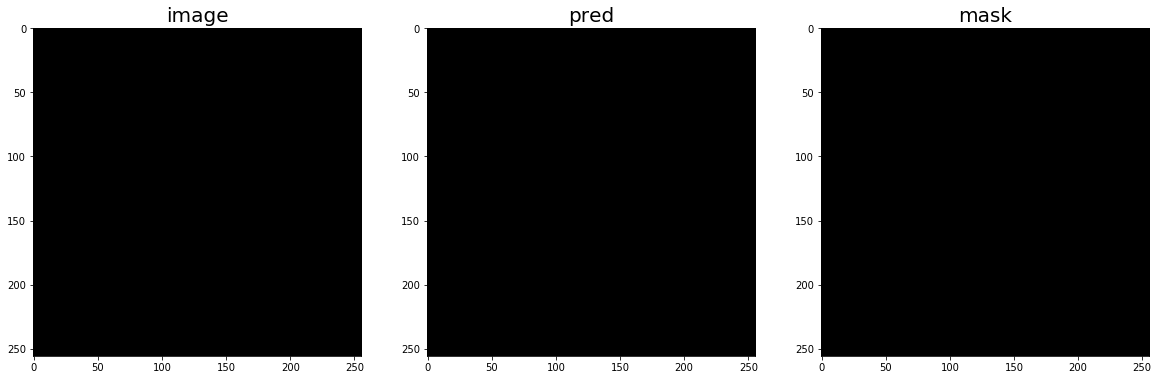

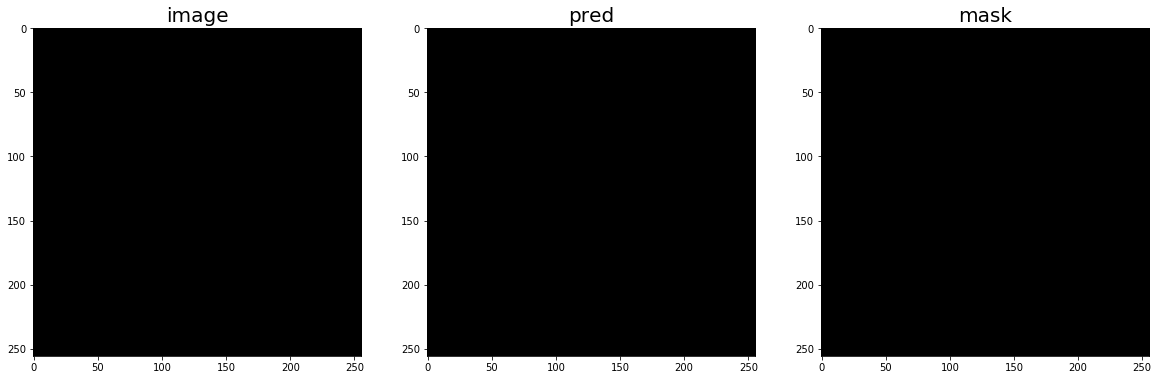

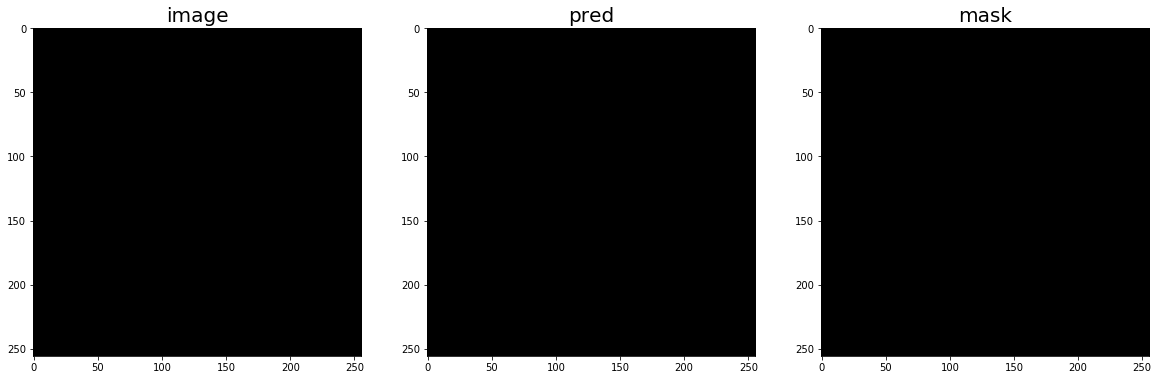

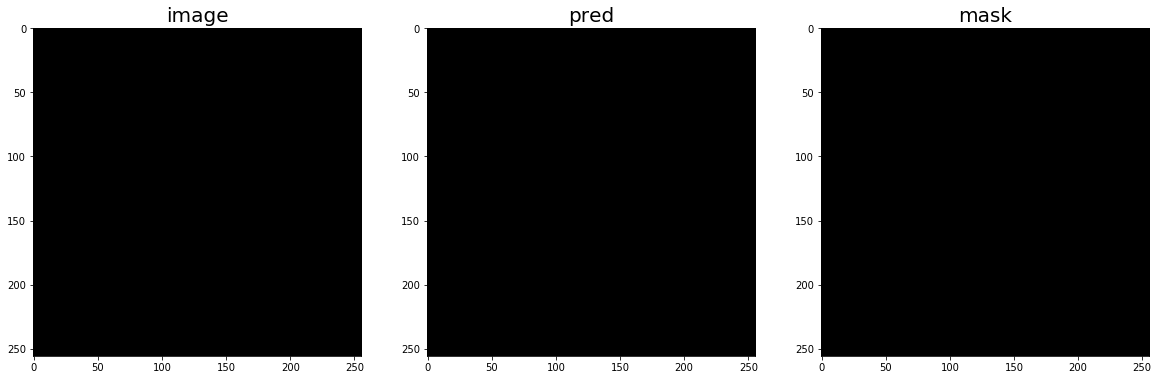

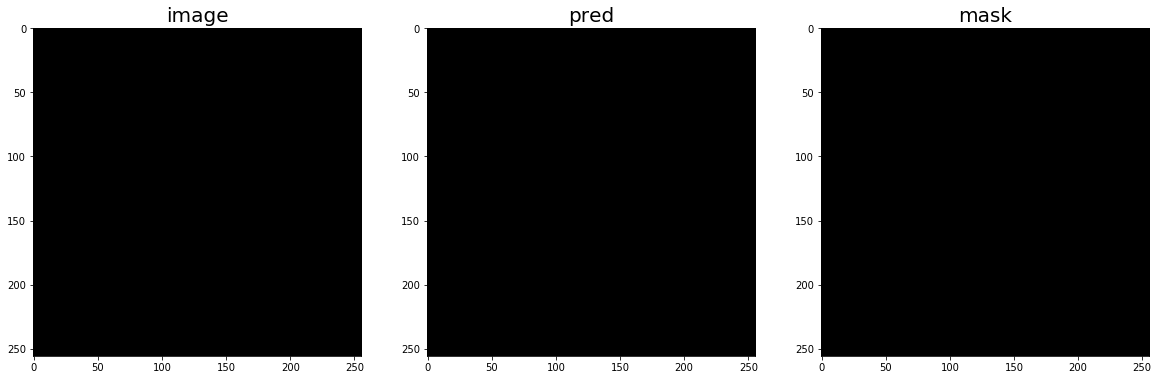

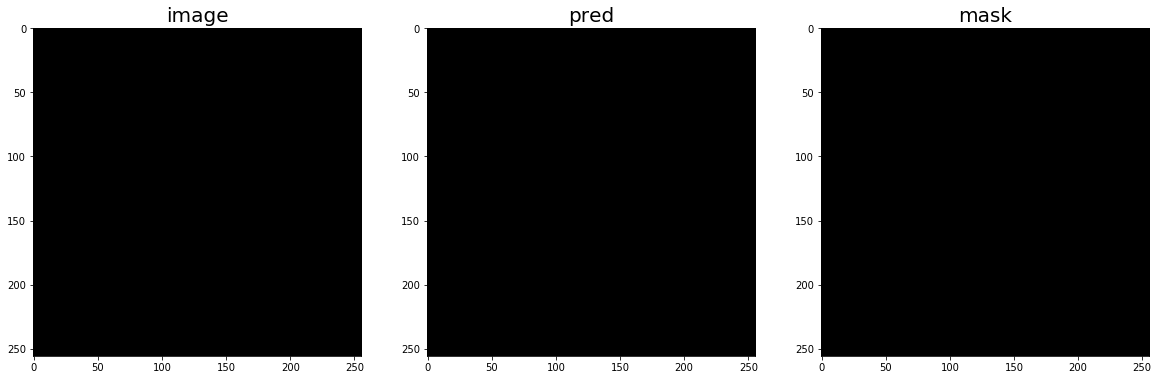

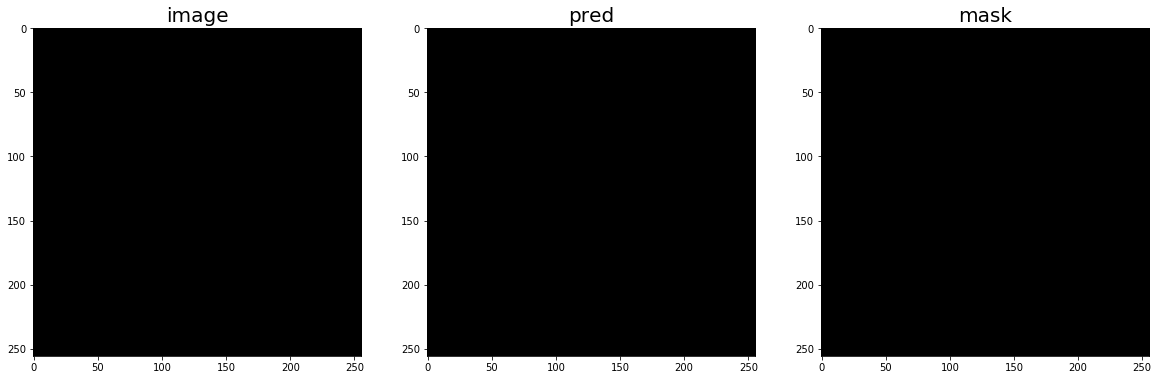

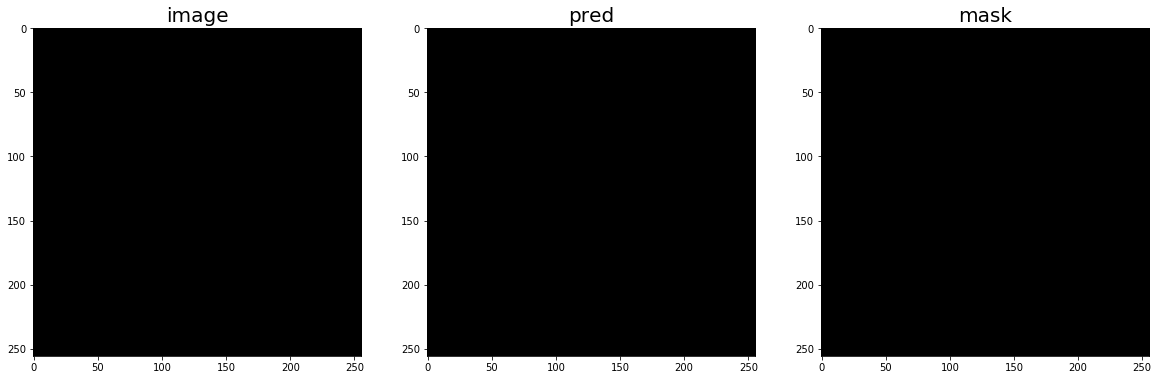

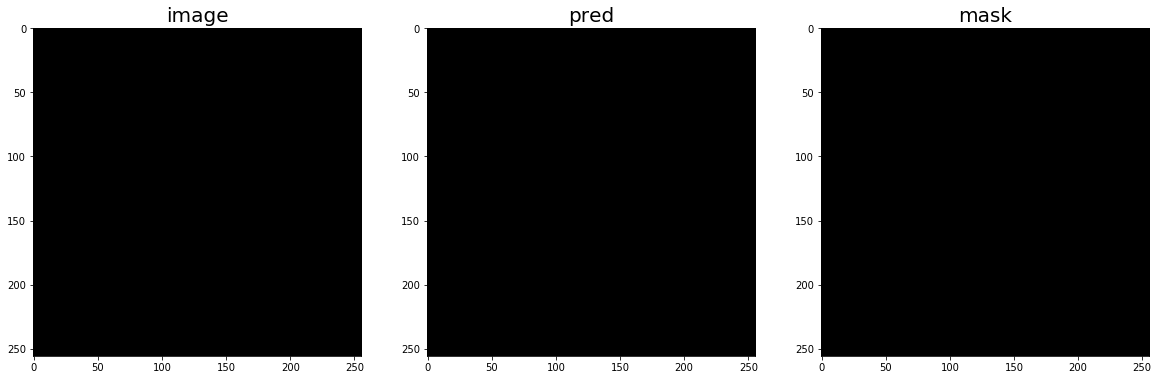

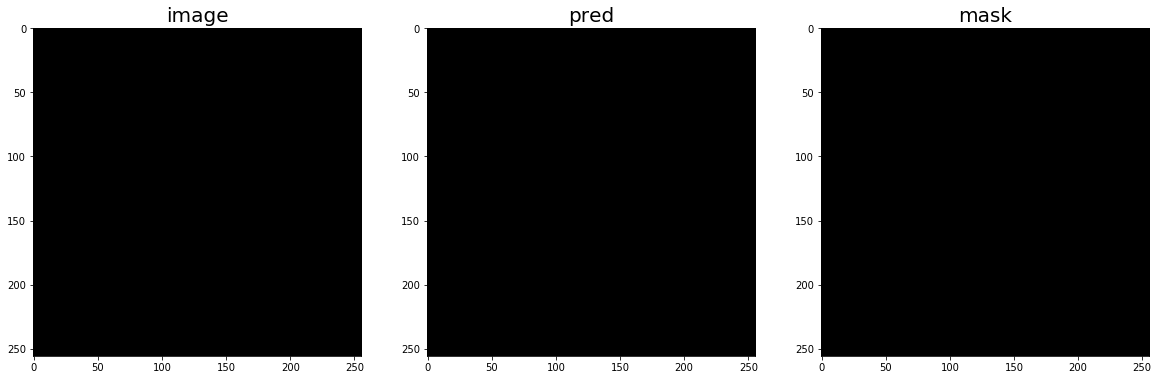

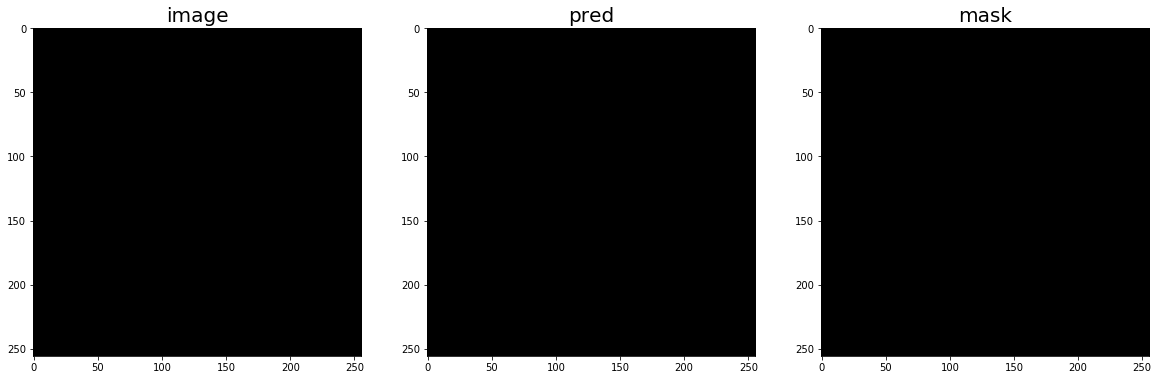

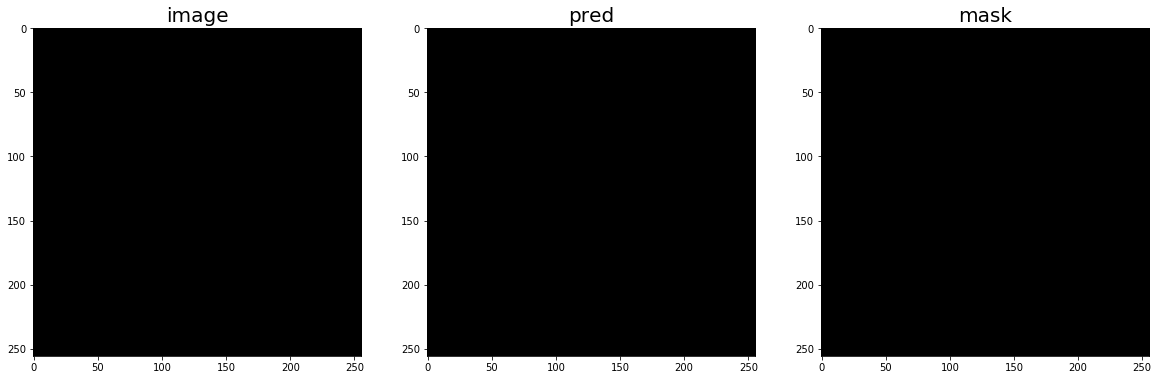

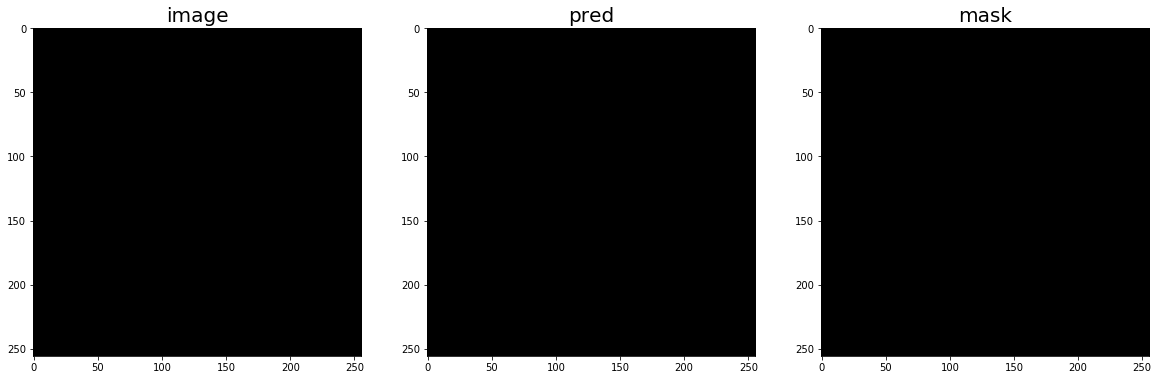

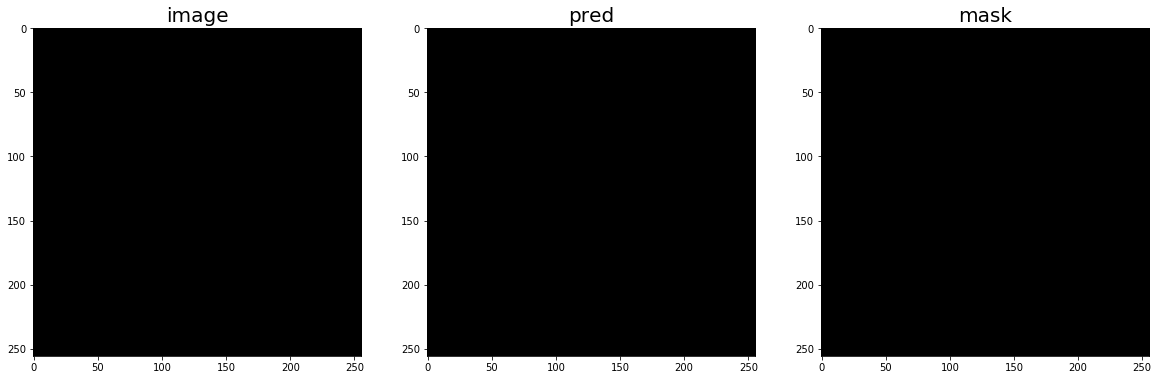

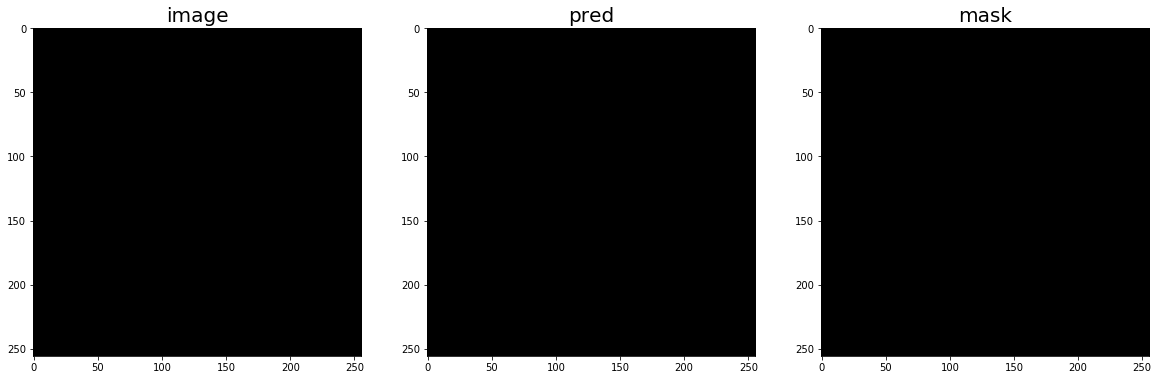

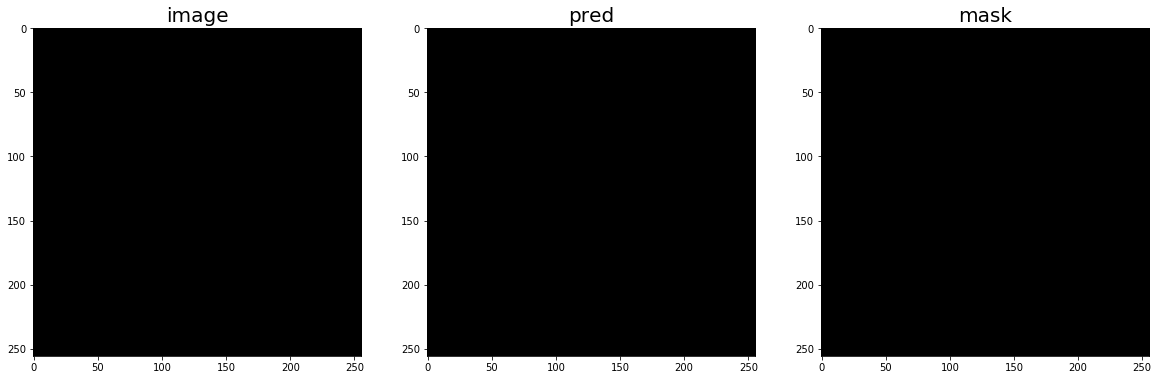

In [141]:
IMG_NUM = 5
image = images[IMG_NUM]
pred = preds[IMG_NUM]
mask = masks[IMG_NUM]
for i in range(image.shape[0]):
    plot_predictions(image[i], pred[i], mask[i])

In [142]:
eval_preds(preds, masks)

0.9360043071974579

## Skull Stripping with predicted Brain Mask

1. Predict Brain Mask
2. Perform weighted normalization part of raw image that corresponds to the brain mask
3. Extract the brain from the raw image using the mask

In [22]:
learner.load('DL_Brain_NoTL_MR_9_epochs_3e-2');

In [23]:
data1 = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, test_ds=test1_ds, bs=3)
data2 = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, test_ds=test2_ds, bs=3)

In [ ]:
%precision

In [1]:
images, preds, masks = get_img_pred_masks(learner, data1, validation=False)

NameError: name 'get_img_pred_masks' is not defined

In [28]:
for i in range(len(preds)):
    name = str(test1_mask[i]).split("/")[-1]
    brain_mask = preds[i]
    np.save("/data/public/Segmentation_Dataset/MR_Dataset/test1/brain_pred/{name}".format(name=name), brain_mask)
    image = images[i]
    image =  normalize(image, brain_mask)
    skull_stripped = extract_brain(image, brain_mask)
    np.save("/data/public/Segmentation_Dataset/MR_Dataset/test1/skull_stripped_pred/{name}".format(name=name), skull_stripped)

In [24]:
images, preds, masks = predict(learner, data2, validation=False)

In [25]:
for i in range(len(preds)):
    name = str(test2_mask[i]).split("/")[-1]
    brain_mask = preds[i]
    np.save("/data/public/Segmentation_Dataset/MR_Dataset/test2/brain_pred/{name}".format(name=name), brain_mask)
    image = images[i]
    image =  normalize(image, brain_mask)
    skull_stripped = extract_brain(image, brain_mask)
    np.save("/data/public/Segmentation_Dataset/MR_Dataset/test2/skull_stripped_pred/{name}".format(name=name), skull_stripped)
    
    